In [39]:
import os, sys, json, pickle, random
from collections import OrderedDict
from copy import deepcopy

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import matthews_corrcoef, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, rdMolDescriptors, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Scaffolds import MurckoScaffold

import optuna
from optuna.trial import Trial

import matplotlib.pyplot as plt
import seaborn as sns

# -------------------- [0. g-mlp 모듈 경로] --------------------
GMLP_DIR = "/home/minji/g-mlp"
if GMLP_DIR not in sys.path:
    sys.path.append(GMLP_DIR)
from g_mlp import gMLP


# -------------------- [1. 공통 유틸/환경] --------------------
def set_seed(seed=700):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # 추가: GPU 연산의 무작위성 제거
    if torch.cuda.is_available():
        torch.use_deterministic_algorithms(True)
        os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    else:
        # CPU 환경에서 무작위성 제거
        torch.use_deterministic_algorithms(True, warn_only=True)
        

set_seed(700)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
# -------------------- [2. 피처 생성 유틸] --------------------
def to_numpy_bitvect(bitvect, n_bits=None, drop_first=False):
    if n_bits is None:
        n_bits = bitvect.GetNumBits()
    arr = np.zeros((n_bits,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(bitvect, arr)
    if drop_first:
        arr = arr[1:]
    return arr.astype(np.float32)

def get_ecfp(mol, radius=2, nbits=1024):
    return to_numpy_bitvect(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nbits), n_bits=nbits)

def get_maccs(mol):
    bv = MACCSkeys.GenMACCSKeys(mol)
    return to_numpy_bitvect(bv, n_bits=bv.GetNumBits(), drop_first=True)

def get_avalon(mol, nbits=512):
    from rdkit.Avalon import pyAvalonTools
    return to_numpy_bitvect(pyAvalonTools.GetAvalonFP(mol, nbits), n_bits=nbits)

def get_topological_torsion(mol, nbits=1024):
    bv = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=nbits)
    return to_numpy_bitvect(bv, n_bits=nbits)

def get_rdkit_desc(mol):
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([d[0] for d in Descriptors._descList])
    try:
        descs = calc.CalcDescriptors(mol)
        descs = np.array(descs, dtype=np.float32)
        descs = np.nan_to_num(descs, nan=0.0, posinf=0.0, neginf=0.0)
    except Exception:
        descs = np.zeros(len(Descriptors._descList), dtype=np.float32)
    return descs

def get_rdkit_descriptor_length():
    return len(Descriptors._descList)

In [41]:
# -------------------- [3. 임베딩 로드 & 차원 감지] --------------------
# 함수명과 내부 변수명을 범용적으로 변경 (MolE도 처리 가능하게 함)
def load_molecular_embeddings(embed_paths: dict):
    embed_data, embed_dims = {}, {} # 변수명 변경: scage_embed_dicts -> embed_data, scage_dims -> embed_dims
    
    for name, path in embed_paths.items(): 
        try:
            df = pd.read_csv(path)
        except Exception:
            embed_data[name] = {}
            embed_dims[name] = 0
            continue
        
        def canon(s):
            m = Chem.MolFromSmiles(s)
            return Chem.MolToSmiles(m, canonical=True) if m else None

        df['smiles'] = df['smiles'].apply(canon)
        df = df.dropna(subset=['smiles']).reset_index(drop=True)

        embed_cols = [c for c in df.columns if c != 'smiles']
        dim = len(embed_cols)
        
        embed_dims[name] = dim  # embed_dims에 차원 저장
        embed_data[name] = {
            row['smiles']: row[embed_cols].to_numpy(dtype=np.float32, copy=False)
            for _, row in df.iterrows()
        }
    
    return embed_data, embed_dims # 리턴 변수명 변경

In [42]:
# -------------------- [4. 기대 차원 계산 + 안전 결합] --------------------
def compute_expected_dims(fp_types, embed_dims: dict): # <- 인자명 변경: embed_dims 사용
    expected = OrderedDict()
    for t in fp_types:
        if t == 'ecfp':
            expected[t] = 1024
        elif t == 'avalon':
            expected[t] = 512
        elif t == 'maccs':
            expected[t] = 166
        elif t == 'tt':
            expected[t] = 1024
        elif t == 'rdkit':
            expected[t] = get_rdkit_descriptor_length()
            
        elif 'mole' in t: # <--- MolE 임베딩 추가 (768차원 기본값)
            default_dim = 768
            expected[t] = embed_dims.get(t, default_dim) if embed_dims.get(t, 0) > 0 else default_dim
            
        elif 'scage' in t: # <--- SCAGE 임베딩 수정 (embed_dims 사용)
            default_dim = 512
            expected[t] = embed_dims.get(t, default_dim) if embed_dims.get(t, 0) > 0 else default_dim
            
        else:
            raise ValueError(f"Unknown fp_type: {t}")
    return expected

def safe_fit_to_dim(vec: np.ndarray, target_dim: int) -> np.ndarray:
    if vec is None:
        return np.zeros(target_dim, dtype=np.float32)
    vec = vec.astype(np.float32, copy=False)
    if np.any(np.isnan(vec)) or np.any(np.isinf(vec)):
        vec = np.nan_to_num(vec, nan=0.0, posinf=0.0, neginf=0.0)
    cur = vec.shape[0]
    if cur == target_dim:
        return vec
    elif cur < target_dim:
        pad = np.zeros(target_dim - cur, dtype=np.float32)
        return np.concatenate([vec, pad], axis=0)
    else:
        return vec[:target_dim]

# scage_embed_dicts -> embed_dicts 로 인자명 변경
def make_feature_vector(mol, smiles, fp_types, expected_dims, embed_dicts):
    chunks = []
    for t in fp_types:
        dim = expected_dims[t]
        try:
            if t == 'ecfp':
                vec = get_ecfp(mol, radius=2, nbits=dim)
            elif t == 'avalon':
                vec = get_avalon(mol, nbits=dim)
            elif t == 'maccs':
                vec = get_maccs(mol)
            elif t == 'tt':
                vec = get_topological_torsion(mol, nbits=dim)
            elif t == 'rdkit':
                vec = get_rdkit_desc(mol)
            # MolE 포함 모든 임베딩을 embed_dicts에서 조회
            elif 'scage' in t or 'mole' in t: 
                vec = embed_dicts.get(t, {}).get(smiles, None)
            else:
                vec = None
        except Exception:
            vec = None
        chunks.append(safe_fit_to_dim(vec, dim))
    feat = np.concatenate(chunks, axis=0)
    feat = np.nan_to_num(feat, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    return feat

In [43]:
# -------------------- [5. Dataset] --------------------
class ScageConcatDataset(data.Dataset):
    # 인자명 변경: scage_paths -> embed_paths
    def __init__(self, label_path, embed_paths: dict, fp_types, expected_dims=None):
        df = pd.read_csv(label_path)
        df = df[['smiles', 'p_np']].rename(columns={'smiles': 'smiles', 'p_np': 'label'})
        df['label'] = df['label'].replace({'BBB-': 0, 'BBB+': 1})
        df = df.drop_duplicates(subset='smiles').reset_index(drop=True)

        # 함수명 변경 및 변수명 변경: load_scage_embeddings -> load_molecular_embeddings
        self.embed_dicts, embed_dims = load_molecular_embeddings(embed_paths)

        if expected_dims is None:
            # embed_dims 전달
            expected_dims = compute_expected_dims(fp_types, embed_dims) 
        self.expected_dims = expected_dims
        self.fp_types = list(fp_types)

        def canon(s):
            m = Chem.MolFromSmiles(s)
            return Chem.MolToSmiles(m, canonical=True) if m else None

        df['smiles'] = df['smiles'].apply(canon)
        df = df.dropna(subset=['smiles']).reset_index(drop=True)

        features, labels, failed = [], [], []
        for _, row in tqdm(df.iterrows(), total=len(df), desc="Generating Features"):
            smi = row['smiles']
            mol = Chem.MolFromSmiles(smi)
            if mol is None:
                failed.append(smi)
                continue
            # make_feature_vector 호출 시 self.embed_dicts 전달
            feat = make_feature_vector(mol, smi, self.fp_types, self.expected_dims, self.embed_dicts) 
            if feat is None or feat.ndim != 1:
                failed.append(smi)
                continue
            features.append(feat)
            labels.append(row['label'])

        self.features = torch.tensor(np.stack(features, axis=0), dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.df = df[~df['smiles'].isin(failed)].reset_index(drop=True)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [44]:
## -------------------- [6. 스플릿 + RDKit 정규화 (토글)] --------------------
def split_then_normalize(
    dataset: ScageConcatDataset,
    split_mode: str = "scaffold",
    train_ratio: float = 0.8,
    val_ratio: float = 0.1,
    seed: int = 700
):
    set_seed(seed)
    df = dataset.df.copy()

    def get_scaffold(smi):
        m = Chem.MolFromSmiles(smi)
        return Chem.MolToSmiles(MurckoScaffold.GetScaffoldForMol(m)) if m else None

    df['scaffold'] = df['smiles'].apply(get_scaffold)
    groups = list(df.groupby('scaffold').groups.values())

    if split_mode == "scaffold":
        groups = sorted(groups, key=lambda g: len(g), reverse=True)
    elif split_mode == "random_scaffold":
        rnd = random.Random(seed)
        rnd.shuffle(groups)
    else:
        raise ValueError("split_mode must be 'scaffold' or 'random_scaffold'")

    n = len(df)
    train_cap = int(round(train_ratio * n))
    val_cap   = int(round(val_ratio   * n))

    train_idx, val_idx, test_idx = [], [], []
    for g in groups:
        g = list(g)
        if len(train_idx) + len(g) <= train_cap:
            train_idx += g
        elif len(val_idx) + len(g) <= val_cap:
            val_idx += g
        else:
            test_idx += g

    def pick(idxs):
        return dataset.features[idxs], dataset.labels[idxs]

    X_train, y_train = pick(train_idx)
    X_val,   y_val   = pick(val_idx)
    X_test,  y_test  = pick(test_idx)

    rd_start, rd_end = None, None
    offset = 0
    for t in dataset.fp_types:
        dim = dataset.expected_dims[t]
        if t == 'rdkit':
            rd_start, rd_end = offset, offset + dim
            break
        offset += dim

    scaler = None
    if rd_start is not None:
        scaler = StandardScaler().fit(X_train[:, rd_start:rd_end])
        X_train[:, rd_start:rd_end] = torch.tensor(scaler.transform(X_train[:, rd_start:rd_end]), dtype=torch.float32)
        X_val[:, rd_start:rd_end]   = torch.tensor(scaler.transform(X_val[:, rd_start:rd_end]),   dtype=torch.float32)
        X_test[:, rd_start:rd_end]  = torch.tensor(scaler.transform(X_test[:, rd_start:rd_end]),  dtype=torch.float32)

    return (
        data.TensorDataset(X_train, y_train),
        data.TensorDataset(X_val,   y_val),
        data.TensorDataset(X_test,  y_test),
        scaler, (rd_start, rd_end),
        (train_idx, val_idx, test_idx)
    )

In [45]:
# -------------------- [7. 모델] --------------------
class MultiModalGMLPFromFlat(nn.Module):
    def __init__(self, mod_dims: OrderedDict, d_model=512, d_ffn=1024, depth=4, dropout=0.2, use_gated_pool=True):
        super().__init__()
        self.mod_names = list(mod_dims.keys())
        self.mod_dims = [mod_dims[n] for n in self.mod_names]
        self.in_features = sum(self.mod_dims)
        self.seq_len = len(self.mod_names)
        self.use_gated_pool = use_gated_pool

        self.proj = nn.ModuleDict({name: nn.Linear(in_dim, d_model) for name, in_dim in zip(self.mod_names, self.mod_dims)})
        self.backbone = gMLP(seq_len=self.seq_len, d_model=d_model, d_ffn=d_ffn, num_layers=depth)
        self.norm = nn.LayerNorm(d_model)
        if use_gated_pool:
            self.alpha = nn.Parameter(torch.zeros(self.seq_len))
        self.head = nn.Linear(d_model, 1)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        chunks = torch.split(x, self.mod_dims, dim=1)
        tokens = [self.proj[name](chunk) for name, chunk in zip(self.mod_names, chunks)]
        X = torch.stack(tokens, dim=1)
        X = self.backbone(X)
        if self.use_gated_pool:
            w = torch.softmax(self.alpha, dim=0)
            Xp = (X * w.view(1, -1, 1)).sum(dim=1)
        else:
            Xp = X.mean(dim=1)
        Xp = self.drop(self.norm(Xp))
        logits = self.head(Xp).squeeze(-1)
        return logits
        
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [46]:
## -------------------- [8. 학습/평가 루틴] --------------------
def train_model(model, optimizer, train_loader, val_loader, loss_fn, num_epochs=50, patience=10):
    best_val = float('inf'); best_state = None; bad = 0
    for epoch in range(num_epochs):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            optimizer.step()
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                val_loss += loss_fn(model(x), y).item()
        val_loss /= len(val_loader)
        
        if val_loss < best_val:
            best_val = val_loss
            best_state = deepcopy(model.state_dict())
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                break
    if best_state:
        model.load_state_dict(best_state)
    return model

def eval_model(model, loader):
    model.eval()
    y_true, y_prob, y_pred = [], [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            probs = torch.sigmoid(logits).cpu().numpy()
            pred = (probs > 0.5).astype(int)
            y_prob.extend(probs)
            y_pred.extend(pred)
            y_true.extend(y.numpy())
    cm = confusion_matrix(y_true, y_pred)
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        sensitivity = recall_score(y_true, y_pred, zero_division=0)
    else:
        specificity, sensitivity = 0.0, 0.0
    return {
        'accuracy': round(accuracy_score(y_true, y_pred), 3),
        'precision': round(precision_score(y_true, y_pred, zero_division=0), 3),
        'recall': round(sensitivity, 3),
        'f1': round(f1_score(y_true, y_pred, zero_division=0), 3),
        'roc_auc': round(roc_auc_score(y_true, y_prob) if len(set(y_true)) > 1 else 0.0, 3),
        'mcc': round(matthews_corrcoef(y_true, y_pred), 3),
        'sensitivity': sensitivity,
        'specificity': specificity,
    }

In [47]:
# -------------------- [9. 스플릿 인덱스 저장/로드 (SCAGE 공정 비교용)] --------------------
def save_split_indices(out_dir, tag, split_indices):
    os.makedirs(out_dir, exist_ok=True)
    train_idx, val_idx, test_idx = split_indices
    np.save(os.path.join(out_dir, f"train_idx_{tag}.npy"), np.array(train_idx, dtype=np.int64))
    np.save(os.path.join(out_dir, f"val_idx_{tag}.npy"),   np.array(val_idx,   dtype=np.int64))
    np.save(os.path.join(out_dir, f"test_idx_{tag}.npy"),  np.array(test_idx,  dtype=np.int64))

def load_split_indices(path, tag):
    train_idx = np.load(os.path.join(path, f"train_idx_{tag}.npy"))
    val_idx = np.load(os.path.join(path, f"val_idx_{tag}.npy"))
    test_idx = np.load(os.path.join(path, f"test_idx_{tag}.npy"))
    return train_idx, val_idx, test_idx
# -------------------- [10. 구성/스케일러 저장·로드] --------------------
def save_config(cfg_path, config: dict):
    with open(cfg_path, 'w') as f:
        json.dump(config, f, indent=2)

def load_config(cfg_path):
    with open(cfg_path, 'r') as f:
        return json.load(f)

def save_scaler(path, scaler):
    with open(path, 'wb') as f:
        pickle.dump(scaler, f)

def load_scaler(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [10]:
if __name__ == "__main__":
    # (A) 실험 스위치
    split_mode = "scaffold" # "scaffold" | "random_scaffold"
    
    # (A-1) 반복 실험을 위한 시드 리스트
    seeds = [42, 100, 200, 300, 400, 500, 600, 700, 800, 900]
    
    # (A-2) 결과를 저장할 리스트
    results = []

    # (L) 반복문 시작
    for seed in seeds:
        print("\n" + "="*80)
        print(f"--- [STARTING NEW RUN] Split Mode: {split_mode}, Seed: {seed} ---")
        print("="*80)
        
        # (B) 경로/설정 — BBBP(2039)만 사용
        label_path = '/home/minji/scage/BBB/bench_label.csv'
        mole_path = '/home/minji/mole_public/MolE_embed_base_bbb.csv'
        
        # 딕셔너리 구문 오류 수정 (scage2 뒤에 콤마 추가)
        embed_paths = {
            'scage1': '/home/minji/scage/BBB/bench_embed.csv',
            'scage2' : '/home/minji/scage/BBB/bench_atom_embed.csv', # <-- 콤마 추가됨
            'mole' : mole_path
        }
        # 'mole' 태그를 특징 목록에 추가
        fp_types = ['rdkit', 'scage1', 'mole']

        # (C) Dataset & dims
        # 수정된 함수와 인자명 사용
        dataset = ScageConcatDataset(label_path, embed_paths, fp_types=fp_types)
        expected_dims = dataset.expected_dims
        mod_dims = OrderedDict((t, expected_dims[t]) for t in fp_types)

        # (D) Split + RDKit normalize (8:1:1)
        train_ds, val_ds, test_ds, scaler, (rd_start, rd_end), split_indices = split_then_normalize(
            dataset, split_mode=split_mode, train_ratio=0.8, val_ratio=0.1, seed=seed
        )

        # (E) 스플릿 저장(→ SCAGE도 같은 인덱스로 학습/평가 가능)
        split_dir = "./splits"
        tag = f"final_{split_mode}_seed{seed}"
        save_split_indices(split_dir, tag, split_indices)
        print(f"[Save] split indices -> {split_dir} (tag={tag})")

        # (F) DataLoader
        train_loader = data.DataLoader(train_ds, batch_size=128, shuffle=True)
        val_loader   = data.DataLoader(val_ds,   batch_size=128, shuffle=False)
        test_loader  = data.DataLoader(test_ds,  batch_size=128, shuffle=False)
        
        # --- 클래스 분포 분석 및 시각화 ---
        def plot_class_distribution(train_labels, val_labels, test_labels, seed):
            labels_map = {0: 'Negative', 1: 'Positive'}
            train_counts = pd.Series(train_labels).map(labels_map).value_counts(normalize=True).sort_index()
            val_counts = pd.Series(val_labels).map(labels_map).value_counts(normalize=True).sort_index()
            test_counts = pd.Series(test_labels).map(labels_map).value_counts(normalize=True).sort_index()

            counts_df = pd.DataFrame({
                'Train': train_counts,
                'Validation': val_counts,
                'Test': test_counts
            }).fillna(0)

            fig, ax = plt.subplots(figsize=(8, 6))
            counts_df.T.plot(kind='bar', stacked=False, ax=ax, rot=0)
            ax.set_title(f'Class Distribution by Split (Seed: {seed})')
            ax.set_ylabel('Proportion')
            ax.set_xlabel('Dataset Split')
            ax.legend(title='Class')
            plt.tight_layout()
            
            os.makedirs("./artifacts", exist_ok=True)
            plt.savefig(f'./artifacts/class_distribution_{split_mode}_seed{seed}.png')
            plt.close()

        y_train = train_ds.tensors[1].cpu().numpy()
        y_val = val_ds.tensors[1].cpu().numpy()
        y_test = test_ds.tensors[1].cpu().numpy()

        print(f"\n--- [Info] Class distribution for seed {seed} ---")
        print(f"Train: Positive={np.mean(y_train):.2f}, Negative={1-np.mean(y_train):.2f}")
        print(f"Validation: Positive={np.mean(y_val):.2f}, Negative={1-np.mean(y_val):.2f}")
        print(f"Test: Positive={np.mean(y_test):.2f}, Negative={1-np.mean(y_test):.2f}")
        
        plot_class_distribution(y_train, y_val, y_test, seed)

        # (G) Model
        set_seed(seed)
        model = MultiModalGMLPFromFlat(
            mod_dims=mod_dims, d_model=512, d_ffn=1048, depth=4, dropout=0.2, use_gated_pool=True
        ).to(device)

        # (H) pos_weight (옵션)
        pos_weight = None
        try:
            n_pos = (y_train == 1).sum()
            n_neg = (y_train == 0).sum()
            if n_pos > 0:
                pos_weight = torch.tensor([max(n_neg / n_pos, 1.0)], dtype=torch.float32, device=device)
                print(f"[Info] Using pos_weight={pos_weight.item():.4f} (neg/pos={n_neg}/{n_pos})")
        except Exception as e:
            print(f"[Warn] pos_weight auto-calc skipped: {e}")

        optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
        loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight) if pos_weight is not None else nn.BCEWithLogitsLoss()

        # (I) Train
        print(f"--- [STEP 1] Training gMLP on BBBP (split_mode={split_mode}) ---")
        model = train_model(model, optimizer, train_loader, val_loader, loss_fn, num_epochs=50, patience=10)
        print("\n--- [STEP 1.5] Evaluating on BBBP Validation Split ---")
        baseline_val_metrics = eval_model(model, val_loader)
        
        # (J) Test eval (== 공식 벤치마크 성능 지표)
        print("\n--- [STEP 2] Evaluating on BBBP Test Split ---")
        metrics = eval_model(model, test_loader)
        
        # (J-1) 각 시드별 결과 저장
        metrics['seed'] = seed
        metrics['train_pos_ratio'] = np.mean(y_train)
        metrics['val_pos_ratio'] = np.mean(y_val)
        metrics['test_pos_ratio'] = np.mean(y_test)
        results.append(metrics)
        
        # (K) 아티팩트 저장 (모드 태그로 구분)
        model_path  = f"./artifacts/gmlp_best_model_{tag}.pth"
        cfg_path    = f"./artifacts/feature_config_{tag}.json"
        scaler_path = f"./artifacts/rdkit_scaler_{tag}.pkl"
        torch.save(model.state_dict(), model_path)
        cfg = {
            "fp_types": fp_types,
            "mod_dims": {k: int(v) for k, v in mod_dims.items()},
            "rd_slice": [rd_start, rd_end] if rd_start is not None else None,
            "split_mode": split_mode,
            "seed": seed,
            "model_hparams": {"d_model": 512, "d_ffn": 1048, "depth": 4, "dropout": 0.2, "use_gated_pool": True},
            "train_params": {"lr": 1e-4, "weight_decay": 1e-5, "num_epochs": 50, "patience": 10},
            "class_balance": {"n_pos": int(n_pos) if 'n_pos' in locals() else None,
                               "n_neg": int(n_neg) if 'n_neg' in locals() else None,
                               "pos_weight": float(pos_weight.item()) if pos_weight is not None else None}
        }
        save_config(cfg_path, cfg)
        if scaler is not None:
            save_scaler(scaler_path, scaler)
    
    # (M) 최종 결과 요약 및 출력
    print("\n" + "="*80)
    print("--- [FINAL SUMMARY] Average Performance Across 10 Seeds ---")
    print("="*80)
    
    # pandas DataFrame으로 변환하여 평균 계산
    results_df = pd.DataFrame(results).set_index('seed')
    summary = results_df.mean(numeric_only=True)
    std_dev = results_df.std(numeric_only=True)
    
    for metric in summary.index:
        print(f"{metric:<18}| Mean: {summary[metric]:.4f} | Std Dev: {std_dev[metric]:.4f}")
    
    # DataFrame을 CSV 파일로 저장 (선택 사항)
    results_df.to_csv(f"./artifacts/final_multi_seed_results_{split_mode}.csv")
    print(f"\n[Save] Detailed results saved to ./artifacts/final_multi_seed_results_{split_mode}.csv")
    print("="*80)


--- [STARTING NEW RUN] Split Mode: scaffold, Seed: 42 ---


[23:36:43] WARNING: not removing hydrogen atom without neighbors
[23:36:44] WARNING: not removing hydrogen atom without neighbors
[23:36:44] WARNING: not removing hydrogen atom without neighbors
[23:36:44] WARNING: not removing hydrogen atom without neighbors
[23:36:44] WARNING: not removing hydrogen atom without neighbors
[23:36:44] WARNING: not removing hydrogen atom without neighbors
[23:36:44] WARNING: not removing hydrogen atom without neighbors
[23:36:44] WARNING: not removing hydrogen atom without neighbors
[23:36:44] WARNING: not removing hydrogen atom without neighbors
[23:36:44] WARNING: not removing hydrogen atom without neighbors
[23:36:44] WARNING: not removing hydrogen atom without neighbors
[23:36:44] WARNING: not removing hydrogen atom without neighbors
[23:36:44] WARNING: not removing hydrogen atom without neighbors
[23:36:44] WARNING: not removing hydrogen atom without neighbors
[23:36:44] WARNING: not removing hydrogen atom without neighbors
[23:36:44] WARNING: not r

[Save] split indices -> ./splits (tag=final_scaffold_seed42)

--- [Info] Class distribution for seed 42 ---
Train: Positive=0.75, Negative=0.25
Validation: Positive=0.73, Negative=0.27
Test: Positive=0.89, Negative=0.11
[Info] Using pos_weight=1.0000 (neg/pos=402/1229)
--- [STEP 1] Training gMLP on BBBP (split_mode=scaffold) ---

--- [STEP 1.5] Evaluating on BBBP Validation Split ---

--- [STEP 2] Evaluating on BBBP Test Split ---

--- [STARTING NEW RUN] Split Mode: scaffold, Seed: 100 ---


[23:36:58] WARNING: not removing hydrogen atom without neighbors
[23:36:58] WARNING: not removing hydrogen atom without neighbors
[23:36:58] WARNING: not removing hydrogen atom without neighbors
[23:36:58] WARNING: not removing hydrogen atom without neighbors
[23:36:58] WARNING: not removing hydrogen atom without neighbors
[23:36:58] WARNING: not removing hydrogen atom without neighbors
[23:36:58] WARNING: not removing hydrogen atom without neighbors
[23:36:58] WARNING: not removing hydrogen atom without neighbors
[23:36:58] WARNING: not removing hydrogen atom without neighbors
[23:36:58] WARNING: not removing hydrogen atom without neighbors
[23:36:58] WARNING: not removing hydrogen atom without neighbors
[23:36:58] WARNING: not removing hydrogen atom without neighbors
[23:36:58] WARNING: not removing hydrogen atom without neighbors
[23:36:58] WARNING: not removing hydrogen atom without neighbors
[23:36:58] WARNING: not removing hydrogen atom without neighbors
[23:36:58] WARNING: not r

[Save] split indices -> ./splits (tag=final_scaffold_seed100)

--- [Info] Class distribution for seed 100 ---
Train: Positive=0.75, Negative=0.25
Validation: Positive=0.73, Negative=0.27
Test: Positive=0.89, Negative=0.11
[Info] Using pos_weight=1.0000 (neg/pos=402/1229)
--- [STEP 1] Training gMLP on BBBP (split_mode=scaffold) ---

--- [STEP 1.5] Evaluating on BBBP Validation Split ---

--- [STEP 2] Evaluating on BBBP Test Split ---

--- [STARTING NEW RUN] Split Mode: scaffold, Seed: 200 ---


[23:37:11] WARNING: not removing hydrogen atom without neighbors
[23:37:11] WARNING: not removing hydrogen atom without neighbors
[23:37:11] WARNING: not removing hydrogen atom without neighbors
[23:37:11] WARNING: not removing hydrogen atom without neighbors
[23:37:11] WARNING: not removing hydrogen atom without neighbors
[23:37:11] WARNING: not removing hydrogen atom without neighbors
[23:37:11] WARNING: not removing hydrogen atom without neighbors
[23:37:11] WARNING: not removing hydrogen atom without neighbors
[23:37:11] WARNING: not removing hydrogen atom without neighbors
[23:37:11] WARNING: not removing hydrogen atom without neighbors
[23:37:11] WARNING: not removing hydrogen atom without neighbors
[23:37:11] WARNING: not removing hydrogen atom without neighbors
[23:37:11] WARNING: not removing hydrogen atom without neighbors
[23:37:11] WARNING: not removing hydrogen atom without neighbors
[23:37:11] WARNING: not removing hydrogen atom without neighbors
[23:37:11] WARNING: not r

[Save] split indices -> ./splits (tag=final_scaffold_seed200)

--- [Info] Class distribution for seed 200 ---
Train: Positive=0.75, Negative=0.25
Validation: Positive=0.73, Negative=0.27
Test: Positive=0.89, Negative=0.11
[Info] Using pos_weight=1.0000 (neg/pos=402/1229)
--- [STEP 1] Training gMLP on BBBP (split_mode=scaffold) ---

--- [STEP 1.5] Evaluating on BBBP Validation Split ---

--- [STEP 2] Evaluating on BBBP Test Split ---

--- [STARTING NEW RUN] Split Mode: scaffold, Seed: 300 ---


[23:37:24] WARNING: not removing hydrogen atom without neighbors
[23:37:24] WARNING: not removing hydrogen atom without neighbors
[23:37:24] WARNING: not removing hydrogen atom without neighbors
[23:37:24] WARNING: not removing hydrogen atom without neighbors
[23:37:24] WARNING: not removing hydrogen atom without neighbors
[23:37:24] WARNING: not removing hydrogen atom without neighbors
[23:37:24] WARNING: not removing hydrogen atom without neighbors
[23:37:24] WARNING: not removing hydrogen atom without neighbors
[23:37:24] WARNING: not removing hydrogen atom without neighbors
[23:37:24] WARNING: not removing hydrogen atom without neighbors
[23:37:24] WARNING: not removing hydrogen atom without neighbors
[23:37:24] WARNING: not removing hydrogen atom without neighbors
[23:37:24] WARNING: not removing hydrogen atom without neighbors
[23:37:24] WARNING: not removing hydrogen atom without neighbors
[23:37:24] WARNING: not removing hydrogen atom without neighbors
[23:37:24] WARNING: not r

[Save] split indices -> ./splits (tag=final_scaffold_seed300)

--- [Info] Class distribution for seed 300 ---
Train: Positive=0.75, Negative=0.25
Validation: Positive=0.73, Negative=0.27
Test: Positive=0.89, Negative=0.11
[Info] Using pos_weight=1.0000 (neg/pos=402/1229)
--- [STEP 1] Training gMLP on BBBP (split_mode=scaffold) ---

--- [STEP 1.5] Evaluating on BBBP Validation Split ---

--- [STEP 2] Evaluating on BBBP Test Split ---

--- [STARTING NEW RUN] Split Mode: scaffold, Seed: 400 ---


[23:37:38] WARNING: not removing hydrogen atom without neighbors
[23:37:38] WARNING: not removing hydrogen atom without neighbors
[23:37:38] WARNING: not removing hydrogen atom without neighbors
[23:37:38] WARNING: not removing hydrogen atom without neighbors
[23:37:38] WARNING: not removing hydrogen atom without neighbors
[23:37:38] WARNING: not removing hydrogen atom without neighbors
[23:37:38] WARNING: not removing hydrogen atom without neighbors
[23:37:38] WARNING: not removing hydrogen atom without neighbors
[23:37:38] WARNING: not removing hydrogen atom without neighbors
[23:37:38] WARNING: not removing hydrogen atom without neighbors
[23:37:38] WARNING: not removing hydrogen atom without neighbors
[23:37:38] WARNING: not removing hydrogen atom without neighbors
[23:37:38] WARNING: not removing hydrogen atom without neighbors
[23:37:38] WARNING: not removing hydrogen atom without neighbors
[23:37:38] WARNING: not removing hydrogen atom without neighbors
[23:37:38] WARNING: not r

[Save] split indices -> ./splits (tag=final_scaffold_seed400)

--- [Info] Class distribution for seed 400 ---
Train: Positive=0.75, Negative=0.25
Validation: Positive=0.73, Negative=0.27
Test: Positive=0.89, Negative=0.11
[Info] Using pos_weight=1.0000 (neg/pos=402/1229)
--- [STEP 1] Training gMLP on BBBP (split_mode=scaffold) ---

--- [STEP 1.5] Evaluating on BBBP Validation Split ---

--- [STEP 2] Evaluating on BBBP Test Split ---

--- [STARTING NEW RUN] Split Mode: scaffold, Seed: 500 ---


[23:37:51] WARNING: not removing hydrogen atom without neighbors
[23:37:51] WARNING: not removing hydrogen atom without neighbors
[23:37:51] WARNING: not removing hydrogen atom without neighbors
[23:37:51] WARNING: not removing hydrogen atom without neighbors
[23:37:51] WARNING: not removing hydrogen atom without neighbors
[23:37:51] WARNING: not removing hydrogen atom without neighbors
[23:37:51] WARNING: not removing hydrogen atom without neighbors
[23:37:51] WARNING: not removing hydrogen atom without neighbors
[23:37:51] WARNING: not removing hydrogen atom without neighbors
[23:37:51] WARNING: not removing hydrogen atom without neighbors
[23:37:51] WARNING: not removing hydrogen atom without neighbors
[23:37:51] WARNING: not removing hydrogen atom without neighbors
[23:37:51] WARNING: not removing hydrogen atom without neighbors
[23:37:51] WARNING: not removing hydrogen atom without neighbors
[23:37:51] WARNING: not removing hydrogen atom without neighbors
[23:37:51] WARNING: not r

[Save] split indices -> ./splits (tag=final_scaffold_seed500)

--- [Info] Class distribution for seed 500 ---
Train: Positive=0.75, Negative=0.25
Validation: Positive=0.73, Negative=0.27
Test: Positive=0.89, Negative=0.11
[Info] Using pos_weight=1.0000 (neg/pos=402/1229)
--- [STEP 1] Training gMLP on BBBP (split_mode=scaffold) ---

--- [STEP 1.5] Evaluating on BBBP Validation Split ---

--- [STEP 2] Evaluating on BBBP Test Split ---

--- [STARTING NEW RUN] Split Mode: scaffold, Seed: 600 ---


[23:38:04] WARNING: not removing hydrogen atom without neighbors
[23:38:04] WARNING: not removing hydrogen atom without neighbors
[23:38:04] WARNING: not removing hydrogen atom without neighbors
[23:38:04] WARNING: not removing hydrogen atom without neighbors
[23:38:04] WARNING: not removing hydrogen atom without neighbors
[23:38:04] WARNING: not removing hydrogen atom without neighbors
[23:38:04] WARNING: not removing hydrogen atom without neighbors
[23:38:05] WARNING: not removing hydrogen atom without neighbors
[23:38:05] WARNING: not removing hydrogen atom without neighbors
[23:38:05] WARNING: not removing hydrogen atom without neighbors
[23:38:05] WARNING: not removing hydrogen atom without neighbors
[23:38:05] WARNING: not removing hydrogen atom without neighbors
[23:38:05] WARNING: not removing hydrogen atom without neighbors
[23:38:05] WARNING: not removing hydrogen atom without neighbors
[23:38:05] WARNING: not removing hydrogen atom without neighbors
[23:38:05] WARNING: not r

[Save] split indices -> ./splits (tag=final_scaffold_seed600)

--- [Info] Class distribution for seed 600 ---
Train: Positive=0.75, Negative=0.25
Validation: Positive=0.73, Negative=0.27
Test: Positive=0.89, Negative=0.11
[Info] Using pos_weight=1.0000 (neg/pos=402/1229)
--- [STEP 1] Training gMLP on BBBP (split_mode=scaffold) ---

--- [STEP 1.5] Evaluating on BBBP Validation Split ---

--- [STEP 2] Evaluating on BBBP Test Split ---

--- [STARTING NEW RUN] Split Mode: scaffold, Seed: 700 ---


[23:38:18] WARNING: not removing hydrogen atom without neighbors
[23:38:18] WARNING: not removing hydrogen atom without neighbors
[23:38:18] WARNING: not removing hydrogen atom without neighbors
[23:38:18] WARNING: not removing hydrogen atom without neighbors
[23:38:18] WARNING: not removing hydrogen atom without neighbors
[23:38:18] WARNING: not removing hydrogen atom without neighbors
[23:38:18] WARNING: not removing hydrogen atom without neighbors
[23:38:18] WARNING: not removing hydrogen atom without neighbors
[23:38:18] WARNING: not removing hydrogen atom without neighbors
[23:38:18] WARNING: not removing hydrogen atom without neighbors
[23:38:18] WARNING: not removing hydrogen atom without neighbors
[23:38:18] WARNING: not removing hydrogen atom without neighbors
[23:38:18] WARNING: not removing hydrogen atom without neighbors
[23:38:18] WARNING: not removing hydrogen atom without neighbors
[23:38:18] WARNING: not removing hydrogen atom without neighbors
[23:38:18] WARNING: not r

[Save] split indices -> ./splits (tag=final_scaffold_seed700)

--- [Info] Class distribution for seed 700 ---
Train: Positive=0.75, Negative=0.25
Validation: Positive=0.73, Negative=0.27
Test: Positive=0.89, Negative=0.11
[Info] Using pos_weight=1.0000 (neg/pos=402/1229)
--- [STEP 1] Training gMLP on BBBP (split_mode=scaffold) ---

--- [STEP 1.5] Evaluating on BBBP Validation Split ---

--- [STEP 2] Evaluating on BBBP Test Split ---

--- [STARTING NEW RUN] Split Mode: scaffold, Seed: 800 ---


[23:38:31] WARNING: not removing hydrogen atom without neighbors
[23:38:31] WARNING: not removing hydrogen atom without neighbors
[23:38:31] WARNING: not removing hydrogen atom without neighbors
[23:38:31] WARNING: not removing hydrogen atom without neighbors
[23:38:31] WARNING: not removing hydrogen atom without neighbors
[23:38:31] WARNING: not removing hydrogen atom without neighbors
[23:38:31] WARNING: not removing hydrogen atom without neighbors
[23:38:31] WARNING: not removing hydrogen atom without neighbors
[23:38:31] WARNING: not removing hydrogen atom without neighbors
[23:38:31] WARNING: not removing hydrogen atom without neighbors
[23:38:31] WARNING: not removing hydrogen atom without neighbors
[23:38:31] WARNING: not removing hydrogen atom without neighbors
[23:38:31] WARNING: not removing hydrogen atom without neighbors
[23:38:31] WARNING: not removing hydrogen atom without neighbors
[23:38:31] WARNING: not removing hydrogen atom without neighbors
[23:38:31] WARNING: not r

[Save] split indices -> ./splits (tag=final_scaffold_seed800)

--- [Info] Class distribution for seed 800 ---
Train: Positive=0.75, Negative=0.25
Validation: Positive=0.73, Negative=0.27
Test: Positive=0.89, Negative=0.11
[Info] Using pos_weight=1.0000 (neg/pos=402/1229)
--- [STEP 1] Training gMLP on BBBP (split_mode=scaffold) ---

--- [STEP 1.5] Evaluating on BBBP Validation Split ---

--- [STEP 2] Evaluating on BBBP Test Split ---

--- [STARTING NEW RUN] Split Mode: scaffold, Seed: 900 ---


[23:38:45] WARNING: not removing hydrogen atom without neighbors
[23:38:45] WARNING: not removing hydrogen atom without neighbors
[23:38:45] WARNING: not removing hydrogen atom without neighbors
[23:38:45] WARNING: not removing hydrogen atom without neighbors
[23:38:45] WARNING: not removing hydrogen atom without neighbors
[23:38:45] WARNING: not removing hydrogen atom without neighbors
[23:38:45] WARNING: not removing hydrogen atom without neighbors
[23:38:45] WARNING: not removing hydrogen atom without neighbors
[23:38:45] WARNING: not removing hydrogen atom without neighbors
[23:38:45] WARNING: not removing hydrogen atom without neighbors
[23:38:45] WARNING: not removing hydrogen atom without neighbors
[23:38:45] WARNING: not removing hydrogen atom without neighbors
[23:38:45] WARNING: not removing hydrogen atom without neighbors
[23:38:45] WARNING: not removing hydrogen atom without neighbors
[23:38:45] WARNING: not removing hydrogen atom without neighbors
[23:38:45] WARNING: not r

[Save] split indices -> ./splits (tag=final_scaffold_seed900)

--- [Info] Class distribution for seed 900 ---
Train: Positive=0.75, Negative=0.25
Validation: Positive=0.73, Negative=0.27
Test: Positive=0.89, Negative=0.11
[Info] Using pos_weight=1.0000 (neg/pos=402/1229)
--- [STEP 1] Training gMLP on BBBP (split_mode=scaffold) ---

--- [STEP 1.5] Evaluating on BBBP Validation Split ---

--- [STEP 2] Evaluating on BBBP Test Split ---

--- [FINAL SUMMARY] Average Performance Across 10 Seeds ---
accuracy          | Mean: 0.8905 | Std Dev: 0.0063
precision         | Mean: 0.9072 | Std Dev: 0.0032
recall            | Mean: 0.9776 | Std Dev: 0.0088
f1                | Mean: 0.9410 | Std Dev: 0.0036
roc_auc           | Mean: 0.8161 | Std Dev: 0.0176
mcc               | Mean: 0.2433 | Std Dev: 0.0392
sensitivity       | Mean: 0.9775 | Std Dev: 0.0088
specificity       | Mean: 0.1727 | Std Dev: 0.0359
train_pos_ratio   | Mean: 0.7535 | Std Dev: 0.0000
val_pos_ratio     | Mean: 0.7304 | Std Dev:

In [48]:
import optuna
from optuna.trial import Trial
# 주의: OrderedDict, deepcopy, torch, np, pd 등 필요한 모든 모듈은 
# 상단에 이미 import 되어 있어야 합니다.

# -------------------- [Optuna - Objective 함수] --------------------
def objective(trial: Trial, train_ds, val_ds, mod_dims, base_seed):
    """
    Optuna Trial을 위한 목적 함수. (데이터 전처리 결과 train_ds, val_ds를 인자로 받음)
    """
    set_seed(base_seed)
    
    # (A) 하이퍼파라미터 제안 (Optuna)
    d_model = trial.suggest_categorical('d_model', [256, 512, 768])
    depth = trial.suggest_int('depth', 2, 8, step=2)
    ffn_multiplier = trial.suggest_categorical('ffn_multiplier', [2, 3, 4])
    d_ffn = d_model * ffn_multiplier
    dropout = trial.suggest_float('dropout', 0.1, 0.4)
    lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True)  # log=True 사용
    
    # (B) DataLoader (사전 정규화된 데이터셋 사용)
    train_loader = data.DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4)
    val_loader   = data.DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=4)

    # (C) 모델 및 옵티마이저 설정
    model = MultiModalGMLPFromFlat(
        mod_dims=mod_dims, d_model=d_model, d_ffn=d_ffn, depth=depth, dropout=dropout, use_gated_pool=True
    ).to(device)
    
    # 클래스 불균형 가중치 계산 (학습 데이터셋의 레이블 사용)
    y_train = train_ds.tensors[1].cpu().numpy()
    n_pos = (y_train == 1).sum()
    n_neg = (y_train == 0).sum()
    pos_weight = None
    if n_pos > 0:
        pos_weight_val = max(n_neg / n_pos, 1.0)
        pos_weight = torch.tensor([pos_weight_val], dtype=torch.float32, device=device)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight) if pos_weight is not None else nn.BCEWithLogitsLoss()

    # (D) 학습
    model = train_model(model, optimizer, train_loader, val_loader, loss_fn, num_epochs=50, patience=10)

    # (E) 검증 세트 평가 및 목표 지표 반환
    metrics = eval_model(model, val_loader)
    roc_auc = metrics['roc_auc']

    # Optuna Pruning 보고
    trial.report(roc_auc, step=50) 
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return roc_auc

# -------------------- [Optuna - 실행 함수] --------------------
def run_optuna_optimization(n_trials=100, base_seed=600):
    
    # (A) 경로/설정 - 기존 설정 유지
    label_path = '/home/minji/scage/BBB/bench_label.csv'
    mole_path = '/home/minji/mole_public/MolE_embed_base_bbb.csv'
    embed_paths = {
        'scage1': '/home/minji/scage/BBB/bench_embed.csv',
        'scage2': '/home/minji/scage/BBB/bench_atom_embed.csv',
        'mole': mole_path
    }
    fp_types = ['rdkit', 'scage1', 'mole']
    split_mode = "scaffold"

    print(f"--- [STEP 1/3] Preparing Data for Optuna (Seed {base_seed}) ---")
    
    # (B) 데이터셋 로드 (특징 벡터 생성까지 포함) - Optuna 루프 밖에서 단 1회 수행
    set_seed(base_seed)
    dataset = ScageConcatDataset(label_path, embed_paths, fp_types=fp_types)
    expected_dims = dataset.expected_dims
    mod_dims = OrderedDict((t, expected_dims[t]) for t in fp_types)

    # (C) Split + RDKit normalize - 단 1회 수행
    train_ds, val_ds, _, _, _, _ = split_then_normalize(
        dataset, split_mode=split_mode, train_ratio=0.8, val_ratio=0.1, seed=base_seed
    )
    
    print(f"[Info] Feature Dims: {mod_dims}")
    print(f"[Info] Train samples: {len(train_ds)}, Validation samples: {len(val_ds)}")
    
    print(f"\n--- [STEP 2/3] Starting Optuna HPO ({n_trials} trials, Seed {base_seed}) ---")

    # (D) Optuna Study 생성
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(seed=base_seed),
        pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=30, interval_steps=10)
    )

    # (E) 최적화 실행: 사전 준비된 데이터셋과 차원 정보를 objective 함수에 전달
    study.optimize(
        lambda trial: objective(trial, train_ds, val_ds, mod_dims, base_seed),
        n_trials=n_trials,
        gc_after_trial=True
    )

    # (F) 결과 출력
    print("\n" + "="*80)
    print("--- [STEP 3/3] Optuna Optimization Finished ---")
    print(f"Best ROC AUC on Validation: {study.best_value:.4f}")
    print("Best Hyperparameters:")
    
    # ffn_multiplier를 d_ffn으로 변환하여 출력
    best_params = study.best_params.copy()
    d_model = best_params.get('d_model', 512)
    ffn_multiplier = best_params.pop('ffn_multiplier', 2)
    best_params['d_ffn'] = d_model * ffn_multiplier
    best_params['lr'] = float(best_params['lr']) # float으로 명확히 변환
    
    for key, value in best_params.items():
        print(f"  {key}: {value}")
    print("="*80)
    
    return best_params


# -------------------- [11. 최종 검증 및 모델 저장 루틴] --------------------

if __name__ == "__main__":
    # -------------------------------------------------------------
    # STEP 1: Optuna 최적화 실행 및 최적 하이퍼파라미터 획득
    # -------------------------------------------------------------
    print("\n" + "#"*80)
    print("########## STEP 1: HYPERPARAMETER OPTIMIZATION (HPO) WITH OPTUNA ##########")
    print("#"*80)
    
    # Optuna 실행 (시드 600 기준)
    best_hparams = run_optuna_optimization(n_trials=100, base_seed=600)
    
    FINAL_BEST_HPARAMS = {
        "d_model": best_hparams['d_model'],
        "d_ffn": best_hparams['d_ffn'],
        "depth": best_hparams['depth'],
        "dropout": best_hparams['dropout'],
        "lr": best_hparams['lr'],
    }
    
    print("\n" + "="*80)
    print(f"✅ OPTUNA BEST HPARAMS: {FINAL_BEST_HPARAMS}")
    print("="*80)
    
    # -------------------------------------------------------------
    # STEP 2: 10개 시드 최종 검증 (Best HParams 적용, 모델 저장)
    # -------------------------------------------------------------
    print("\n" + "#"*80)
    print("########## STEP 2: FINAL EVALUATION ACROSS 10 SEEDS ##########")
    print("#"*80)
    
    split_mode = "scaffold" 
    seeds = [42, 100, 200, 300, 400, 500, 600, 700, 800, 900]
    results = []

    # (B) 경로/특징 설정 (기존과 동일)
    label_path = '/home/minji/scage/BBB/bench_label.csv'
    mole_path = '/home/minji/mole_public/MolE_embed_base_bbb.csv'
    embed_paths = {
        'scage1': '/home/minji/scage/BBB/bench_embed.csv',
        'scage2' : '/home/minji/scage/BBB/bench_atom_embed.csv',
        'mole' : mole_path
    }
    fp_types = ['rdkit', 'scage1', 'mole']

    # (L) 반복문 시작: 10개 시드에 대해 Optuna 최적 모델로 재평가
    for seed in seeds:
        print("\n" + "="*80)
        print(f"--- [FINAL EVAL] Split Mode: {split_mode}, Seed: {seed} ---")
        print(f"--- HParams: d_model={FINAL_BEST_HPARAMS['d_model']}, lr={FINAL_BEST_HPARAMS['lr']:.2e} ---")
        print("="*80)
        
        set_seed(seed)
        
        # (C) Dataset & dims (매 시드마다 데이터셋을 새로 로드하고 분할)
        dataset = ScageConcatDataset(label_path, embed_paths, fp_types=fp_types)
        expected_dims = dataset.expected_dims
        mod_dims = OrderedDict((t, expected_dims[t]) for t in fp_types)

        # (D) Split + RDKit normalize (8:1:1)
        train_ds, val_ds, test_ds, scaler, (rd_start, rd_end), split_indices = split_then_normalize(
            dataset, split_mode=split_mode, train_ratio=0.8, val_ratio=0.1, seed=seed
        )

        # (E) 스플릿 저장 (매 시드마다 인덱스 저장)
        split_dir = "./splits"
        tag = f"final_optimized_{split_mode}_seed{seed}" # 저장 태그 변경: optimized 추가
        save_split_indices(split_dir, tag, split_indices)
        
        # (F) DataLoader
        train_loader = data.DataLoader(train_ds, batch_size=128, shuffle=True)
        val_loader   = data.DataLoader(val_ds, batch_size=128, shuffle=False)
        test_loader  = data.DataLoader(test_ds, batch_size=128, shuffle=False)
        
        # (G) Model - Optuna 최적 하이퍼파라미터 적용!
        model = MultiModalGMLPFromFlat(
            mod_dims=mod_dims, 
            d_model=FINAL_BEST_HPARAMS['d_model'], 
            d_ffn=FINAL_BEST_HPARAMS['d_ffn'], 
            depth=FINAL_BEST_HPARAMS['depth'], 
            dropout=FINAL_BEST_HPARAMS['dropout'], 
            use_gated_pool=True
        ).to(device)

        # (H) pos_weight (옵션)
        y_train = train_ds.tensors[1].cpu().numpy()
        n_pos = (y_train == 1).sum()
        n_neg = (y_train == 0).sum()
        pos_weight = None
        pos_weight_val = 0.0
        if n_pos > 0:
            pos_weight_val = max(n_neg / n_pos, 1.0)
            pos_weight = torch.tensor([pos_weight_val], dtype=torch.float32, device=device)
            print(f"[Info] Using pos_weight={pos_weight_val:.4f} (neg/pos={n_neg}/{n_pos})")

        # (I) Optimizer & Loss - Optuna 최적 학습률 적용!
        optimizer = optim.Adam(model.parameters(), lr=FINAL_BEST_HPARAMS['lr'], weight_decay=1e-5)
        loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight) if pos_weight is not None else nn.BCEWithLogitsLoss()

        # (J) Train
        print(f"--- [STEP 1] Training gMLP on BBBP ---")
        model = train_model(model, optimizer, train_loader, val_loader, loss_fn, num_epochs=50, patience=10)
        
        # (K) Test eval
        print("\n--- [STEP 2] Evaluating on BBBP Test Split ---")
        metrics = eval_model(model, test_loader)
        
        # (L) 아티팩트 저장 (모델 가중치, 설정, 스케일러) ⬅️ 이 부분이 핵심
        artifact_tag = f"optimized_{split_mode}_seed{seed}"
        model_path  = f"./artifacts/gmlp_best_model_{artifact_tag}.pth"
        cfg_path    = f"./artifacts/feature_config_{artifact_tag}.json"
        scaler_path = f"./artifacts/rdkit_scaler_{artifact_tag}.pkl"
        
        torch.save(model.state_dict(), model_path)
        print(f"[Save] Model saved to {model_path}")
        
        cfg = {
            "fp_types": fp_types,
            "mod_dims": {k: int(v) for k, v in mod_dims.items()},
            "rd_slice": [rd_start, rd_end] if rd_start is not None else None,
            "split_mode": split_mode,
            "seed": seed,
            "model_hparams": FINAL_BEST_HPARAMS,
            "train_params": {"lr": FINAL_BEST_HPARAMS['lr'], "weight_decay": 1e-5, "num_epochs": 50, "patience": 10},
            "class_balance": {"n_pos": int(n_pos), "n_neg": int(n_neg), "pos_weight": float(pos_weight_val) if pos_weight is not None else None},
            "test_metrics": metrics # 최종 테스트 성능을 설정 파일에 포함
        }
        save_config(cfg_path, cfg)
        
        if scaler is not None:
            save_scaler(scaler_path, scaler)
            
        # (M) 각 시드별 결과 저장
        metrics['seed'] = seed
        metrics['train_pos_ratio'] = np.mean(y_train)
        metrics['val_pos_ratio'] = np.mean(val_ds.tensors[1].cpu().numpy())
        metrics['test_pos_ratio'] = np.mean(test_ds.tensors[1].cpu().numpy())
        results.append(metrics)
        
    # (N) 최종 결과 요약 및 출력
    print("\n" + "="*80)
    print("--- [FINAL SUMMARY] Optuna Optimized Model Average Performance ---")
    print("="*80)
    
    results_df = pd.DataFrame(results).set_index('seed')
    summary = results_df.mean(numeric_only=True)
    std_dev = results_df.std(numeric_only=True)
    
    for metric in summary.index:
        print(f"{metric:<18}| Mean: {summary[metric]:.4f} | Std Dev: {std_dev[metric]:.4f}")
    
    results_df.to_csv(f"./artifacts/final_optimized_multi_seed_results_{split_mode}.csv")
    print(f"\n[Save] Detailed results saved to ./artifacts/final_optimized_multi_seed_results_{split_mode}.csv")
    print("="*80)


################################################################################
########## STEP 1: HYPERPARAMETER OPTIMIZATION (HPO) WITH OPTUNA ##########
################################################################################
--- [STEP 1/3] Preparing Data for Optuna (Seed 600) ---


[11:27:08] WARNING: not removing hydrogen atom without neighbors
[11:27:08] WARNING: not removing hydrogen atom without neighbors
[11:27:08] WARNING: not removing hydrogen atom without neighbors
[11:27:08] WARNING: not removing hydrogen atom without neighbors
[11:27:08] WARNING: not removing hydrogen atom without neighbors
[11:27:08] WARNING: not removing hydrogen atom without neighbors
[11:27:08] WARNING: not removing hydrogen atom without neighbors
[11:27:08] WARNING: not removing hydrogen atom without neighbors
[11:27:08] WARNING: not removing hydrogen atom without neighbors
[11:27:08] WARNING: not removing hydrogen atom without neighbors
[11:27:08] WARNING: not removing hydrogen atom without neighbors
[11:27:08] WARNING: not removing hydrogen atom without neighbors
[11:27:08] WARNING: not removing hydrogen atom without neighbors
[11:27:08] WARNING: not removing hydrogen atom without neighbors
[11:27:08] WARNING: not removing hydrogen atom without neighbors
[11:27:08] WARNING: not r

[Info] Feature Dims: OrderedDict([('rdkit', 217), ('scage1', 512), ('mole', 768)])
[Info] Train samples: 1631, Validation samples: 204

--- [STEP 2/3] Starting Optuna HPO (100 trials, Seed 600) ---


[I 2025-10-24 11:27:25,510] Trial 0 finished with value: 0.879 and parameters: {'d_model': 768, 'depth': 2, 'ffn_multiplier': 4, 'dropout': 0.13557139665429818, 'lr': 1.0598297972891438e-05}. Best is trial 0 with value: 0.879.
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ec0f7e0a9e0>
Traceback (most recent call last):
  File "/home/minji/anaconda3/envs/rapids-25.02/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/home/minji/anaconda3/envs/rapids-25.02/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1435, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
[I 2025-10-24 11:27:29,515] Trial 1 finished with value: 0.858 and parameters: {'d_model': 768, 'depth': 2, 'ffn_multiplier': 2, 'dropout': 0.37642450172624664, 'lr': 0.00094366894749416


--- [STEP 3/3] Optuna Optimization Finished ---
Best ROC AUC on Validation: 0.8840
Best Hyperparameters:
  d_model: 512
  depth: 4
  dropout: 0.24889781793064544
  lr: 3.54127819853151e-05
  d_ffn: 1024

✅ OPTUNA BEST HPARAMS: {'d_model': 512, 'd_ffn': 1024, 'depth': 4, 'dropout': 0.24889781793064544, 'lr': 3.54127819853151e-05}

################################################################################
########## STEP 2: FINAL EVALUATION ACROSS 10 SEEDS ##########
################################################################################

--- [FINAL EVAL] Split Mode: scaffold, Seed: 42 ---
--- HParams: d_model=512, lr=3.54e-05 ---


[11:35:15] WARNING: not removing hydrogen atom without neighbors
[11:35:15] WARNING: not removing hydrogen atom without neighbors
[11:35:15] WARNING: not removing hydrogen atom without neighbors
[11:35:15] WARNING: not removing hydrogen atom without neighbors
[11:35:15] WARNING: not removing hydrogen atom without neighbors
[11:35:15] WARNING: not removing hydrogen atom without neighbors
[11:35:15] WARNING: not removing hydrogen atom without neighbors
[11:35:15] WARNING: not removing hydrogen atom without neighbors
[11:35:15] WARNING: not removing hydrogen atom without neighbors
[11:35:15] WARNING: not removing hydrogen atom without neighbors
[11:35:15] WARNING: not removing hydrogen atom without neighbors
[11:35:15] WARNING: not removing hydrogen atom without neighbors
[11:35:15] WARNING: not removing hydrogen atom without neighbors
[11:35:15] WARNING: not removing hydrogen atom without neighbors
[11:35:15] WARNING: not removing hydrogen atom without neighbors
[11:35:15] WARNING: not r

[Info] Using pos_weight=1.0000 (neg/pos=402/1229)
--- [STEP 1] Training gMLP on BBBP ---

--- [STEP 2] Evaluating on BBBP Test Split ---
[Save] Model saved to ./artifacts/gmlp_best_model_optimized_scaffold_seed42.pth

--- [FINAL EVAL] Split Mode: scaffold, Seed: 100 ---
--- HParams: d_model=512, lr=3.54e-05 ---


[11:35:29] WARNING: not removing hydrogen atom without neighbors
[11:35:29] WARNING: not removing hydrogen atom without neighbors
[11:35:29] WARNING: not removing hydrogen atom without neighbors
[11:35:29] WARNING: not removing hydrogen atom without neighbors
[11:35:29] WARNING: not removing hydrogen atom without neighbors
[11:35:29] WARNING: not removing hydrogen atom without neighbors
[11:35:29] WARNING: not removing hydrogen atom without neighbors
[11:35:29] WARNING: not removing hydrogen atom without neighbors
[11:35:29] WARNING: not removing hydrogen atom without neighbors
[11:35:29] WARNING: not removing hydrogen atom without neighbors
[11:35:29] WARNING: not removing hydrogen atom without neighbors
[11:35:29] WARNING: not removing hydrogen atom without neighbors
[11:35:29] WARNING: not removing hydrogen atom without neighbors
[11:35:29] WARNING: not removing hydrogen atom without neighbors
[11:35:29] WARNING: not removing hydrogen atom without neighbors
[11:35:29] WARNING: not r

[Info] Using pos_weight=1.0000 (neg/pos=402/1229)
--- [STEP 1] Training gMLP on BBBP ---

--- [STEP 2] Evaluating on BBBP Test Split ---
[Save] Model saved to ./artifacts/gmlp_best_model_optimized_scaffold_seed100.pth

--- [FINAL EVAL] Split Mode: scaffold, Seed: 200 ---
--- HParams: d_model=512, lr=3.54e-05 ---


[11:35:42] WARNING: not removing hydrogen atom without neighbors
[11:35:43] WARNING: not removing hydrogen atom without neighbors
[11:35:43] WARNING: not removing hydrogen atom without neighbors
[11:35:43] WARNING: not removing hydrogen atom without neighbors
[11:35:43] WARNING: not removing hydrogen atom without neighbors
[11:35:43] WARNING: not removing hydrogen atom without neighbors
[11:35:43] WARNING: not removing hydrogen atom without neighbors
[11:35:43] WARNING: not removing hydrogen atom without neighbors
[11:35:43] WARNING: not removing hydrogen atom without neighbors
[11:35:43] WARNING: not removing hydrogen atom without neighbors
[11:35:43] WARNING: not removing hydrogen atom without neighbors
[11:35:43] WARNING: not removing hydrogen atom without neighbors
[11:35:43] WARNING: not removing hydrogen atom without neighbors
[11:35:43] WARNING: not removing hydrogen atom without neighbors
[11:35:43] WARNING: not removing hydrogen atom without neighbors
[11:35:43] WARNING: not r

[Info] Using pos_weight=1.0000 (neg/pos=402/1229)
--- [STEP 1] Training gMLP on BBBP ---

--- [STEP 2] Evaluating on BBBP Test Split ---
[Save] Model saved to ./artifacts/gmlp_best_model_optimized_scaffold_seed200.pth

--- [FINAL EVAL] Split Mode: scaffold, Seed: 300 ---
--- HParams: d_model=512, lr=3.54e-05 ---


[11:35:56] WARNING: not removing hydrogen atom without neighbors
[11:35:56] WARNING: not removing hydrogen atom without neighbors
[11:35:56] WARNING: not removing hydrogen atom without neighbors
[11:35:56] WARNING: not removing hydrogen atom without neighbors
[11:35:56] WARNING: not removing hydrogen atom without neighbors
[11:35:56] WARNING: not removing hydrogen atom without neighbors
[11:35:56] WARNING: not removing hydrogen atom without neighbors
[11:35:56] WARNING: not removing hydrogen atom without neighbors
[11:35:56] WARNING: not removing hydrogen atom without neighbors
[11:35:56] WARNING: not removing hydrogen atom without neighbors
[11:35:56] WARNING: not removing hydrogen atom without neighbors
[11:35:56] WARNING: not removing hydrogen atom without neighbors
[11:35:56] WARNING: not removing hydrogen atom without neighbors
[11:35:56] WARNING: not removing hydrogen atom without neighbors
[11:35:56] WARNING: not removing hydrogen atom without neighbors
[11:35:56] WARNING: not r

[Info] Using pos_weight=1.0000 (neg/pos=402/1229)
--- [STEP 1] Training gMLP on BBBP ---

--- [STEP 2] Evaluating on BBBP Test Split ---
[Save] Model saved to ./artifacts/gmlp_best_model_optimized_scaffold_seed300.pth

--- [FINAL EVAL] Split Mode: scaffold, Seed: 400 ---
--- HParams: d_model=512, lr=3.54e-05 ---


[11:36:10] WARNING: not removing hydrogen atom without neighbors
[11:36:10] WARNING: not removing hydrogen atom without neighbors
[11:36:10] WARNING: not removing hydrogen atom without neighbors
[11:36:10] WARNING: not removing hydrogen atom without neighbors
[11:36:10] WARNING: not removing hydrogen atom without neighbors
[11:36:10] WARNING: not removing hydrogen atom without neighbors
[11:36:10] WARNING: not removing hydrogen atom without neighbors
[11:36:10] WARNING: not removing hydrogen atom without neighbors
[11:36:10] WARNING: not removing hydrogen atom without neighbors
[11:36:10] WARNING: not removing hydrogen atom without neighbors
[11:36:10] WARNING: not removing hydrogen atom without neighbors
[11:36:10] WARNING: not removing hydrogen atom without neighbors
[11:36:10] WARNING: not removing hydrogen atom without neighbors
[11:36:10] WARNING: not removing hydrogen atom without neighbors
[11:36:10] WARNING: not removing hydrogen atom without neighbors
[11:36:10] WARNING: not r

[Info] Using pos_weight=1.0000 (neg/pos=402/1229)
--- [STEP 1] Training gMLP on BBBP ---

--- [STEP 2] Evaluating on BBBP Test Split ---
[Save] Model saved to ./artifacts/gmlp_best_model_optimized_scaffold_seed400.pth

--- [FINAL EVAL] Split Mode: scaffold, Seed: 500 ---
--- HParams: d_model=512, lr=3.54e-05 ---


[11:36:23] WARNING: not removing hydrogen atom without neighbors
[11:36:23] WARNING: not removing hydrogen atom without neighbors
[11:36:23] WARNING: not removing hydrogen atom without neighbors
[11:36:23] WARNING: not removing hydrogen atom without neighbors
[11:36:23] WARNING: not removing hydrogen atom without neighbors
[11:36:23] WARNING: not removing hydrogen atom without neighbors
[11:36:23] WARNING: not removing hydrogen atom without neighbors
[11:36:23] WARNING: not removing hydrogen atom without neighbors
[11:36:23] WARNING: not removing hydrogen atom without neighbors
[11:36:23] WARNING: not removing hydrogen atom without neighbors
[11:36:23] WARNING: not removing hydrogen atom without neighbors
[11:36:23] WARNING: not removing hydrogen atom without neighbors
[11:36:23] WARNING: not removing hydrogen atom without neighbors
[11:36:23] WARNING: not removing hydrogen atom without neighbors
[11:36:23] WARNING: not removing hydrogen atom without neighbors
[11:36:23] WARNING: not r

[Info] Using pos_weight=1.0000 (neg/pos=402/1229)
--- [STEP 1] Training gMLP on BBBP ---

--- [STEP 2] Evaluating on BBBP Test Split ---
[Save] Model saved to ./artifacts/gmlp_best_model_optimized_scaffold_seed500.pth

--- [FINAL EVAL] Split Mode: scaffold, Seed: 600 ---
--- HParams: d_model=512, lr=3.54e-05 ---


[11:36:37] WARNING: not removing hydrogen atom without neighbors
[11:36:37] WARNING: not removing hydrogen atom without neighbors
[11:36:37] WARNING: not removing hydrogen atom without neighbors
[11:36:37] WARNING: not removing hydrogen atom without neighbors
[11:36:37] WARNING: not removing hydrogen atom without neighbors
[11:36:37] WARNING: not removing hydrogen atom without neighbors
[11:36:37] WARNING: not removing hydrogen atom without neighbors
[11:36:37] WARNING: not removing hydrogen atom without neighbors
[11:36:37] WARNING: not removing hydrogen atom without neighbors
[11:36:37] WARNING: not removing hydrogen atom without neighbors
[11:36:37] WARNING: not removing hydrogen atom without neighbors
[11:36:37] WARNING: not removing hydrogen atom without neighbors
[11:36:37] WARNING: not removing hydrogen atom without neighbors
[11:36:37] WARNING: not removing hydrogen atom without neighbors
[11:36:37] WARNING: not removing hydrogen atom without neighbors
[11:36:37] WARNING: not r

[Info] Using pos_weight=1.0000 (neg/pos=402/1229)
--- [STEP 1] Training gMLP on BBBP ---

--- [STEP 2] Evaluating on BBBP Test Split ---
[Save] Model saved to ./artifacts/gmlp_best_model_optimized_scaffold_seed600.pth

--- [FINAL EVAL] Split Mode: scaffold, Seed: 700 ---
--- HParams: d_model=512, lr=3.54e-05 ---


[11:36:51] WARNING: not removing hydrogen atom without neighbors
[11:36:51] WARNING: not removing hydrogen atom without neighbors
[11:36:51] WARNING: not removing hydrogen atom without neighbors
[11:36:51] WARNING: not removing hydrogen atom without neighbors
[11:36:51] WARNING: not removing hydrogen atom without neighbors
[11:36:51] WARNING: not removing hydrogen atom without neighbors
[11:36:51] WARNING: not removing hydrogen atom without neighbors
[11:36:51] WARNING: not removing hydrogen atom without neighbors
[11:36:51] WARNING: not removing hydrogen atom without neighbors
[11:36:51] WARNING: not removing hydrogen atom without neighbors
[11:36:51] WARNING: not removing hydrogen atom without neighbors
[11:36:51] WARNING: not removing hydrogen atom without neighbors
[11:36:51] WARNING: not removing hydrogen atom without neighbors
[11:36:51] WARNING: not removing hydrogen atom without neighbors
[11:36:51] WARNING: not removing hydrogen atom without neighbors
[11:36:51] WARNING: not r

[Info] Using pos_weight=1.0000 (neg/pos=402/1229)
--- [STEP 1] Training gMLP on BBBP ---

--- [STEP 2] Evaluating on BBBP Test Split ---
[Save] Model saved to ./artifacts/gmlp_best_model_optimized_scaffold_seed700.pth

--- [FINAL EVAL] Split Mode: scaffold, Seed: 800 ---
--- HParams: d_model=512, lr=3.54e-05 ---


[11:37:05] WARNING: not removing hydrogen atom without neighbors
[11:37:05] WARNING: not removing hydrogen atom without neighbors
[11:37:05] WARNING: not removing hydrogen atom without neighbors
[11:37:05] WARNING: not removing hydrogen atom without neighbors
[11:37:05] WARNING: not removing hydrogen atom without neighbors
[11:37:05] WARNING: not removing hydrogen atom without neighbors
[11:37:05] WARNING: not removing hydrogen atom without neighbors
[11:37:05] WARNING: not removing hydrogen atom without neighbors
[11:37:05] WARNING: not removing hydrogen atom without neighbors
[11:37:05] WARNING: not removing hydrogen atom without neighbors
[11:37:05] WARNING: not removing hydrogen atom without neighbors
[11:37:05] WARNING: not removing hydrogen atom without neighbors
[11:37:05] WARNING: not removing hydrogen atom without neighbors
[11:37:05] WARNING: not removing hydrogen atom without neighbors
[11:37:05] WARNING: not removing hydrogen atom without neighbors
[11:37:05] WARNING: not r

[Info] Using pos_weight=1.0000 (neg/pos=402/1229)
--- [STEP 1] Training gMLP on BBBP ---

--- [STEP 2] Evaluating on BBBP Test Split ---
[Save] Model saved to ./artifacts/gmlp_best_model_optimized_scaffold_seed800.pth

--- [FINAL EVAL] Split Mode: scaffold, Seed: 900 ---
--- HParams: d_model=512, lr=3.54e-05 ---


[11:37:18] WARNING: not removing hydrogen atom without neighbors
[11:37:18] WARNING: not removing hydrogen atom without neighbors
[11:37:18] WARNING: not removing hydrogen atom without neighbors
[11:37:18] WARNING: not removing hydrogen atom without neighbors
[11:37:18] WARNING: not removing hydrogen atom without neighbors
[11:37:18] WARNING: not removing hydrogen atom without neighbors
[11:37:18] WARNING: not removing hydrogen atom without neighbors
[11:37:18] WARNING: not removing hydrogen atom without neighbors
[11:37:18] WARNING: not removing hydrogen atom without neighbors
[11:37:18] WARNING: not removing hydrogen atom without neighbors
[11:37:18] WARNING: not removing hydrogen atom without neighbors
[11:37:18] WARNING: not removing hydrogen atom without neighbors
[11:37:18] WARNING: not removing hydrogen atom without neighbors
[11:37:18] WARNING: not removing hydrogen atom without neighbors
[11:37:18] WARNING: not removing hydrogen atom without neighbors
[11:37:18] WARNING: not r

[Info] Using pos_weight=1.0000 (neg/pos=402/1229)
--- [STEP 1] Training gMLP on BBBP ---

--- [STEP 2] Evaluating on BBBP Test Split ---
[Save] Model saved to ./artifacts/gmlp_best_model_optimized_scaffold_seed900.pth

--- [FINAL SUMMARY] Optuna Optimized Model Average Performance ---
accuracy          | Mean: 0.8930 | Std Dev: 0.0039
precision         | Mean: 0.9047 | Std Dev: 0.0028
recall            | Mean: 0.9844 | Std Dev: 0.0031
f1                | Mean: 0.9427 | Std Dev: 0.0022
roc_auc           | Mean: 0.8236 | Std Dev: 0.0158
mcc               | Mean: 0.2292 | Std Dev: 0.0402
sensitivity       | Mean: 0.9841 | Std Dev: 0.0031
specificity       | Mean: 0.1409 | Std Dev: 0.0258
train_pos_ratio   | Mean: 0.7535 | Std Dev: 0.0000
val_pos_ratio     | Mean: 0.7304 | Std Dev: 0.0000
test_pos_ratio    | Mean: 0.8922 | Std Dev: 0.0000

[Save] Detailed results saved to ./artifacts/final_optimized_multi_seed_results_scaffold.csv


[11:55:35] WARNING: not removing hydrogen atom without neighbors
[11:55:35] WARNING: not removing hydrogen atom without neighbors
[11:55:35] WARNING: not removing hydrogen atom without neighbors
[11:55:35] WARNING: not removing hydrogen atom without neighbors
[11:55:35] WARNING: not removing hydrogen atom without neighbors
[11:55:35] WARNING: not removing hydrogen atom without neighbors
[11:55:35] WARNING: not removing hydrogen atom without neighbors
[11:55:35] WARNING: not removing hydrogen atom without neighbors
[11:55:36] Unusual charge on atom 42 number of radical electrons set to zero
[11:55:40] WARNING: not removing hydrogen atom without neighbors
[11:55:40] WARNING: not removing hydrogen atom without neighbors
[11:55:40] WARNING: not removing hydrogen atom without neighbors
[11:55:40] WARNING: not removing hydrogen atom without neighbors
[11:55:40] WARNING: not removing hydrogen atom without neighbors
[11:55:40] WARNING: not removing hydrogen atom without neighbors
[11:55:40] WA

--- Starting Soft Voting Inference on Optimized Models ---
New Data Samples: 12361
✅ Seed 42 model prediction successful.


/tmp/ipykernel_40279/1812050614.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVICE))
/tmp/ipykernel_40279/

✅ Seed 100 model prediction successful.
✅ Seed 200 model prediction successful.


/tmp/ipykernel_40279/1812050614.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVICE))
/tmp/ipykernel_40279/

✅ Seed 300 model prediction successful.
✅ Seed 400 model prediction successful.


/tmp/ipykernel_40279/1812050614.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVICE))
/tmp/ipykernel_40279/

✅ Seed 500 model prediction successful.
✅ Seed 600 model prediction successful.


/tmp/ipykernel_40279/1812050614.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVICE))
/tmp/ipykernel_40279/

✅ Seed 700 model prediction successful.
✅ Seed 800 model prediction successful.


/tmp/ipykernel_40279/1812050614.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVICE))


✅ Seed 900 model prediction successful.

--- Soft Voting Ensemble Performance (Optuna Optimized Models) ---
Models used: 10
Accuracy:      0.794
Precision:     0.846
Recall (Sens.):0.850
Specificity:   0.677
F1-score:      0.848
ROC-AUC:       0.854
MCC:           0.528

Confusion Matrix:
[[2706 1293]
 [1254 7108]]


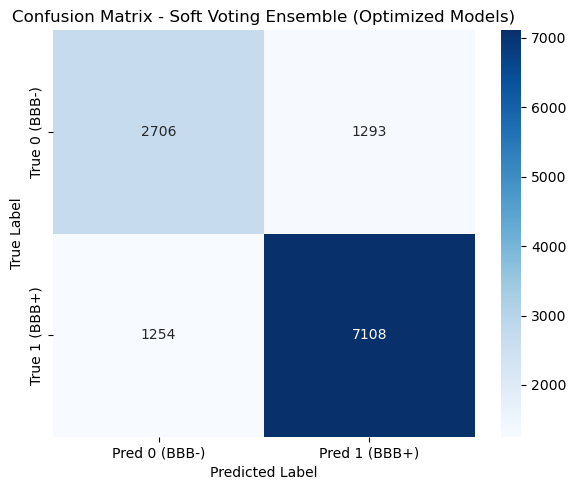


✅ Soft voting ensemble 결과 저장 완료 → ./artifacts/optimized_new_bbb_predictions_soft_ensemble.csv


In [49]:
import pandas as pd
import numpy as np
import os
import torch
from collections import OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef, confusion_matrix
)
# 주의: load_config, load_scaler, MultiModalGMLPFromFlat, 
# ScageConcatDataset, eval_model 등의 함수/클래스는 상단에 정의되어 있어야 합니다.

# -------------------- [앙상블 추론 및 평가 설정] --------------------
seeds = [42, 100, 200, 300, 400, 500, 600, 700, 800, 900]
split_mode = "scaffold" 
base_dir = "./artifacts"

# 새 데이터 경로 설정 (이전 셀에서 사용된 경로를 재사용)
NEW_LABEL_PATH = "/home/minji/scage/BBB/my_label.csv"
NEW_EMBED_PATHS = {
    'scage1': '/home/minji/scage/BBB/my_embed.csv',
    'mole': '/home/minji/mole_public/MolE_embed_base_my.csv'
}
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------- [1. 공통 특징 및 설정 로드] --------------------
# 특징 타입과 차원 정보를 얻기 위해 시드 42의 설정 로드 (모든 시드에서 동일)
try:
    CONFIG_42_PATH = f"{base_dir}/feature_config_optimized_{split_mode}_seed42.json"
    config_42 = load_config(CONFIG_42_PATH)
    mod_dims = OrderedDict(config_42['mod_dims'])
    fp_types = config_42['fp_types']
    rd_slice_info = config_42['rd_slice']
except FileNotFoundError:
    print(f"🚨 에러: 초기 설정 파일 ({CONFIG_42_PATH})이 누락되었습니다. 이전 셀 실행을 확인하세요.")
    raise

# 새 데이터셋 특징 생성 (Soft Voting을 위해 라벨/SMILES 구조를 유지)
new_dataset_raw = ScageConcatDataset(NEW_LABEL_PATH, NEW_EMBED_PATHS, fp_types, expected_dims=mod_dims)
raw_features = new_dataset_raw.features.clone()
raw_df = new_dataset_raw.df[['smiles', 'label']].copy()
dfs = []


# -------------------- [2. 시드별 예측 수행 및 저장] --------------------
print("="*80)
print("--- Starting Soft Voting Inference on Optimized Models ---")
print(f"New Data Samples: {len(raw_df)}")
print("="*80)

for seed in seeds:
    artifact_tag = f"optimized_{split_mode}_seed{seed}"
    
    # 파일 경로 정의
    cfg_path    = f"{base_dir}/feature_config_{artifact_tag}.json"
    model_path  = f"{base_dir}/gmlp_best_model_{artifact_tag}.pth"
    scaler_path = f"{base_dir}/rdkit_scaler_{artifact_tag}.pkl"

    try:
        # A. 설정 및 스케일러 로드
        cfg = load_config(cfg_path)
        hparams = cfg['model_hparams']
        scaler = load_scaler(scaler_path) if os.path.exists(scaler_path) else None
        
        # B. 모델 초기화 및 가중치 로드
        model = MultiModalGMLPFromFlat(
            mod_dims=mod_dims,
            d_model=hparams['d_model'],
            d_ffn=hparams['d_ffn'],
            depth=hparams['depth'],
            dropout=hparams['dropout'],
            use_gated_pool=True
        ).to(DEVICE)
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
        model.eval()

        # C. 데이터 복제 및 정규화 적용 (시드별 Scaler 적용)
        X_pred = raw_features.clone()
        if rd_slice_info is not None and scaler is not None:
            rd_start, rd_end = rd_slice_info
            X_pred[:, rd_start:rd_end] = torch.tensor(
                scaler.transform(X_pred[:, rd_start:rd_end].cpu().numpy()), 
                dtype=torch.float32
            )
            
        # D. 예측 수행
        with torch.no_grad():
            X_tensor = X_pred.to(DEVICE)
            logits = model(X_tensor)
            probs = torch.sigmoid(logits).cpu().numpy()
        
        # E. 결과 정리 및 리스트에 추가
        df_result = raw_df[['smiles', 'label']].copy()
        df_result[f'prob_{seed}'] = probs
        dfs.append(df_result)
        print(f"✅ Seed {seed} model prediction successful.")
        
    except FileNotFoundError:
        print(f"⚠️ 경고: Seed {seed}의 아티팩트 파일이 누락되어 건너뜁니다.")
    except Exception as e:
        print(f"❌ 에러: Seed {seed} 모델 로드/예측 중 오류 발생: {e}")


# -------------------- [3. Soft Voting 앙상블 및 평가] --------------------
if len(dfs) < 2:
    print("❌ 앙상블을 수행하기에 충분한 모델이 로드되지 않았습니다. (최소 2개 모델 필요)")
else:
    # A. smiles/label 기준으로 병합
    merged = dfs[0]
    for df in dfs[1:]:
        merged = merged.merge(df, on=['smiles', 'label'], how='inner')

    # B. Soft Voting (확률 평균)
    prob_cols = [col for col in merged.columns if col.startswith('prob_')]
    merged['ensemble_prob'] = merged[prob_cols].mean(axis=1)
    merged['ensemble_pred'] = (merged['ensemble_prob'] > 0.5).astype(int)

    # C. 성능 평가
    y_true = merged['label']
    y_pred = merged['ensemble_pred']
    y_prob = merged['ensemble_prob']

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    mcc = matthews_corrcoef(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    # Specificity 계산
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    else:
        specificity = 0.0 # 클래스가 하나만 있을 경우

    # D. 결과 출력
    print("\n" + "="*80)
    print("--- Soft Voting Ensemble Performance (Optuna Optimized Models) ---")
    print("="*80)
    print(f"Models used: {len(prob_cols)}")
    print(f"Accuracy:      {acc:.3f}")
    print(f"Precision:     {prec:.3f}")
    print(f"Recall (Sens.):{rec:.3f}")
    print(f"Specificity:   {specificity:.3f}")
    print(f"F1-score:      {f1:.3f}")
    print(f"ROC-AUC:       {auc:.3f}")
    print(f"MCC:           {mcc:.3f}")
    print("\nConfusion Matrix:")
    print(cm)
    
    # E. Confusion Matrix 시각화
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred 0 (BBB-)', 'Pred 1 (BBB+)'],
                yticklabels=['True 0 (BBB-)', 'True 1 (BBB+)'])
    plt.title("Confusion Matrix - Soft Voting Ensemble (Optimized Models)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    # F. 결과 저장
    save_path = f"{base_dir}/optimized_new_bbb_predictions_soft_ensemble.csv"
    merged.to_csv(save_path, index=False)
    print(f"\n✅ Soft voting ensemble 결과 저장 완료 → {save_path}")

In [27]:
import torch
import pandas as pd
from collections import OrderedDict
from rdkit import Chem
from sklearn.preprocessing import StandardScaler
import pickle, json, os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- 2. 저장된 모델/설정 불러오기 ----
tag = "final_scaffold_seed400"
cfg_path = f"./artifacts/feature_config_{tag}.json"
model_path = f"./artifacts/gmlp_best_model_{tag}.pth"
scaler_path = f"./artifacts/rdkit_scaler_{tag}.pkl"

cfg = load_config(cfg_path)
scaler = load_scaler(scaler_path)

# ---- 3. 모델 초기화 & 파라미터 로드 ----
mod_dims = OrderedDict(cfg["mod_dims"])
model = MultiModalGMLPFromFlat(
    mod_dims=mod_dims,
    d_model=cfg["model_hparams"]["d_model"],
    d_ffn=cfg["model_hparams"]["d_ffn"],
    depth=cfg["model_hparams"]["depth"],
    dropout=cfg["model_hparams"]["dropout"],
    use_gated_pool=cfg["model_hparams"]["use_gated_pool"]
).to(device)

model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# ---- 4. 새로운 BBB 데이터 로드 ----
label_path = "/home/minji/scage/BBB/my_label.csv"  # 새 데이터
embed_paths = {
    'scage1': '/home/minji/scage/BBB/my_embed.csv',
    'mole': '/home/minji/mole_public/MolE_embed_base_my.csv'
}
fp_types = cfg["fp_types"]

dataset = ScageConcatDataset(label_path, embed_paths, fp_types)
X = dataset.features.clone()

# ---- 5. RDKit descriptor normalization ----
rd_start, rd_end = cfg["rd_slice"]
if rd_start is not None and scaler is not None:
    X[:, rd_start:rd_end] = torch.tensor(scaler.transform(X[:, rd_start:rd_end]), dtype=torch.float32)

# ---- 6. 예측 수행 ----
with torch.no_grad():
    X = X.to(device)
    logits = model(X)
    probs = torch.sigmoid(logits).cpu().numpy()
    preds = (probs > 0.5).astype(int)

# ---- 7. 결과 정리 및 저장 ----
dataset.df['pred_prob'] = probs
dataset.df['pred_class'] = preds
dataset.df.to_csv("./artifacts/final_new_bbb_predictions_400.csv", index=False)

print(dataset.df[['smiles', 'pred_prob', 'pred_class']].head())


/tmp/ipykernel_38783/2441848473.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))
[00:06:44] WARNING: n

                                              smiles  pred_prob  pred_class
0   O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O   0.129095           0
1  COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...   0.039064           0
2                             Oc1c(I)cc(Cl)c2cccnc12   0.827032           1
3                         CCNC(=NCCSCc1ncccc1Br)NC#N   0.693000           1
4  CN1CC[C@]23c4c5ccc(OC6O[C@H](C(=O)O)[C@@H](O)[...   0.438296           0


Accuracy:     0.796
Precision:    0.844
Recall:       0.858
Specificity:  0.667
F1-score:     0.851
ROC-AUC:      0.852
MCC:          0.530

Confusion Matrix:
[[2669 1330]
 [1188 7174]]


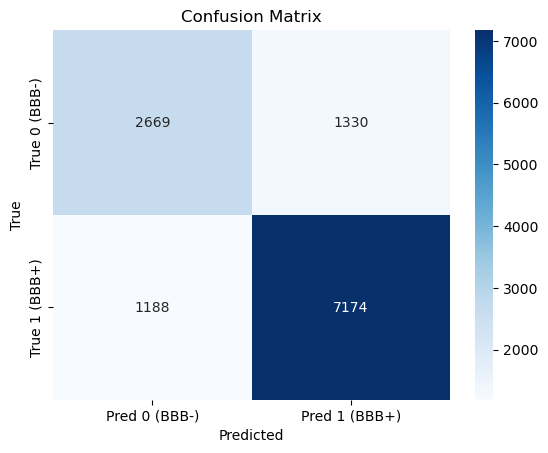

In [1]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef, confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. 결과 로드 ---
df = pd.read_csv("./artifacts/final_new_bbb_predictions_600.csv")

y_true = df["label"]
y_pred = df["pred_class"]
y_prob = df["pred_prob"]

# --- 2. 기본 성능 지표 계산 ---
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
auc = roc_auc_score(y_true, y_prob)
mcc = matthews_corrcoef(y_true, y_pred)

# --- 3. 혼동행렬 (TP, FP, TN, FN) ---
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
sensitivity = rec  # 동일 의미

# --- 4. 결과 출력 ---
print(f"Accuracy:     {acc:.3f}")
print(f"Precision:    {prec:.3f}")
print(f"Recall:       {rec:.3f}")
print(f"Specificity:  {specificity:.3f}")
print(f"F1-score:     {f1:.3f}")
print(f"ROC-AUC:      {auc:.3f}")
print(f"MCC:          {mcc:.3f}")
print("\nConfusion Matrix:")
print(cm)

# --- 5. 시각화 (Confusion Matrix) ---
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0 (BBB-)', 'Pred 1 (BBB+)'],
            yticklabels=['True 0 (BBB-)', 'True 1 (BBB+)'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [28]:
import pandas as pd
import numpy as np

# ---- 1. seed 리스트 및 파일 경로 ----
seeds = [42, 100, 200, 300, 400, 500, 600, 700, 800, 900]
base_dir = "./artifacts"

# ---- 2. 모든 예측 파일 불러오기 ----
dfs = []
for seed in seeds:
    path = f"{base_dir}/final_new_bbb_predictions_{seed}.csv"
    df = pd.read_csv(path)[['smiles', 'pred_class']]
    df = df.rename(columns={'pred_class': f'pred_{seed}'})
    dfs.append(df)

# ---- 3. 모든 결과를 smiles 기준으로 병합 ----
merged = dfs[0]
for df in dfs[1:]:
    merged = merged.merge(df, on='smiles', how='inner')

# ---- 4. 다수결 앙상블 수행 ----
pred_cols = [f'pred_{s}' for s in seeds]

def majority_vote(row):
    votes = row[pred_cols].values
    ones = np.sum(votes)
    zeros = len(votes) - ones
    
    if ones > zeros:
        return 1
    elif zeros > ones:
        return 0
    else:
        # 동점인 경우 seed 600 결과 우선
        return row['pred_600']

merged['ensemble_pred'] = merged.apply(majority_vote, axis=1)

# ---- 5. optional: 확률 평균 기반도 같이 계산 (선택) ----
# probs_df = []
# for seed in seeds:
#     path = f"{base_dir}/new_bbb_predictions_{seed}.csv"
#     df = pd.read_csv(path)[['smiles', 'pred_prob']]
#     df = df.rename(columns={'pred_prob': f'prob_{seed}'})
#     probs_df.append(df)
# probs_merged = probs_df[0]
# for df in probs_df[1:]:
#     probs_merged = probs_merged.merge(df, on='smiles', how='inner')
# merged['ensemble_prob'] = probs_merged[[f'prob_{s}' for s in seeds]].mean(axis=1)

# ---- 8. 결과 저장 ----
merged.to_csv(f"{base_dir}/final_new_bbb_predictions_ensemble.csv", index=False)
print("앙상블 결과 저장 완료:", f"{base_dir}/final_new_bbb_predictions_ensemble.csv")


앙상블 결과 저장 완료: ./artifacts/final_new_bbb_predictions_ensemble.csv


Accuracy:     0.794
Precision:    0.847
Recall:       0.848
Specificity:  0.681
F1-score:     0.847
ROC-AUC:      0.764
MCC:          0.528

Confusion Matrix:
[[2722 1277]
 [1274 7088]]


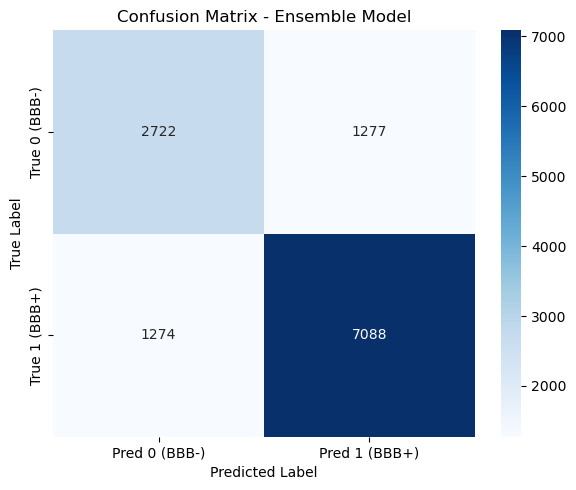

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef, confusion_matrix
)

# ---- 1. 파일 경로 ----
ensemble_path = "./artifacts/final_new_bbb_predictions_ensemble.csv"
label_path = "/home/minji/scage/BBB/my_label.csv"

# ---- 2. 데이터 불러오기 ----
pred_df = pd.read_csv(ensemble_path)[['smiles', 'ensemble_pred']]
label_df = pd.read_csv(label_path)[['smiles', 'p_np']]  # label = 0 or 1

# ---- 3. 병합 ----
df = pd.merge(pred_df, label_df, on='smiles', how='inner')

# ---- 4. 실제 라벨 및 예측값 ----
y_true = df['p_np']
y_pred = df['ensemble_pred']

# ---- 5. 지표 계산 ----
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, matthews_corrcoef, confusion_matrix
)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

# ---- 6. 결과 출력 ----
print(f"Accuracy:     {acc:.3f}")
print(f"Precision:    {prec:.3f}")
print(f"Recall:       {rec:.3f}")
print(f"Specificity:  {specificity:.3f}")
print(f"F1-score:     {f1:.3f}")
print(f"ROC-AUC:      {auc:.3f}")
print(f"MCC:          {mcc:.3f}")
print("\nConfusion Matrix:")
print(cm)

# ---- 7. 시각화 (Confusion Matrix) ----
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0 (BBB-)', 'Pred 1 (BBB+)'],
            yticklabels=['True 0 (BBB-)', 'True 1 (BBB+)'])
plt.title("Confusion Matrix - Ensemble Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


Accuracy:     0.789
Precision:    0.849
Recall:       0.838
Specificity:  0.688
F1-score:     0.843
ROC-AUC:      0.852
MCC:          0.523

Confusion Matrix:
[[2752 1247]
 [1355 7007]]


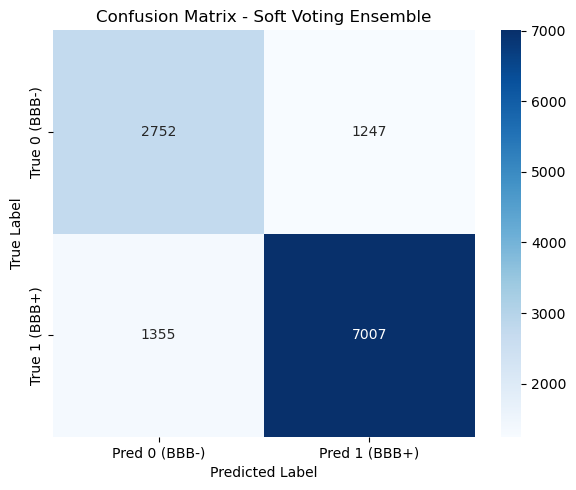


✅ Soft voting ensemble 결과 저장 완료 → ./artifacts/new_bbb_predictions_soft_ensemble.csv


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef, confusion_matrix
)

# ---- 1. 설정 ----
seeds = [42, 100, 200, 300, 400, 500, 600, 700, 800, 900]
base_dir = "./artifacts"

# ---- 2. 모든 예측 확률 + 라벨 불러오기 ----
dfs = []
for seed in seeds:
    path = f"{base_dir}/new_bbb_predictions_{seed}.csv"
    df = pd.read_csv(path)[['smiles', 'label', 'pred_prob']]
    df = df.rename(columns={'pred_prob': f'prob_{seed}'})
    dfs.append(df)

# ---- 3. smiles 기준으로 병합 ----
merged = dfs[0]
for df in dfs[1:]:
    merged = merged.merge(df, on=['smiles', 'label'], how='inner')

# ---- 4. Soft Voting (확률 평균) ----
merged['ensemble_prob'] = merged[[f'prob_{s}' for s in seeds]].mean(axis=1)
merged['ensemble_pred'] = (merged['ensemble_prob'] > 0.5).astype(int)

# ---- 5. 성능 평가 ----
y_true = merged['label']
y_pred = merged['ensemble_pred']
y_prob = merged['ensemble_prob']

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)
mcc = matthews_corrcoef(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

# ---- 6. 결과 출력 ----
print(f"Accuracy:     {acc:.3f}")
print(f"Precision:    {prec:.3f}")
print(f"Recall:       {rec:.3f}")
print(f"Specificity:  {specificity:.3f}")
print(f"F1-score:     {f1:.3f}")
print(f"ROC-AUC:      {auc:.3f}")
print(f"MCC:          {mcc:.3f}")
print("\nConfusion Matrix:")
print(cm)

# ---- 7. Confusion Matrix 시각화 ----
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0 (BBB-)', 'Pred 1 (BBB+)'],
            yticklabels=['True 0 (BBB-)', 'True 1 (BBB+)'])
plt.title("Confusion Matrix - Soft Voting Ensemble")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# ---- 8. 결과 저장 ----
save_path = f"{base_dir}/new_bbb_predictions_soft_ensemble.csv"
merged.to_csv(save_path, index=False)
print(f"\n✅ Soft voting ensemble 결과 저장 완료 → {save_path}")


In [62]:
# -------------------- [11. 메인: BBBP만으로 학습/평가] --------------------
if __name__ == "__main__":
    # (A) 실험 스위치
    split_mode = "random_scaffold"  # "scaffold" | "random_scaffold"
    seed = 42

    # (B) 경로/설정 — BBBP(2039)만 사용
    label_path = '/home/minji/Downloads/bbbp.csv'
    scage_paths = {
        'scage1': '/home/minji/scage/BBB/bench_embed.csv',
        'scage2' : '/home/minji/scage/BBB/bench_atom_embed.csv'
    }
    fp_types = ['ecfp', 'avalon', 'rdkit', 'maccs', 'tt', 'scage1']

    # (C) Dataset & dims
    dataset = ScageConcatDataset(label_path, scage_paths, fp_types=fp_types)
    expected_dims = dataset.expected_dims
    mod_dims = OrderedDict((t, expected_dims[t]) for t in fp_types)

    # (D) Split + RDKit normalize (8:1:1)
    train_ds, val_ds, test_ds, scaler, (rd_start, rd_end), split_indices = split_then_normalize(
        dataset, split_mode=split_mode, train_ratio=0.8, val_ratio=0.1, seed=seed
    )

    # (E) 스플릿 저장(→ SCAGE도 같은 인덱스로 학습/평가 가능)
    split_dir = "./splits"
    tag = f"{split_mode}_seed{seed}"
    save_split_indices(split_dir, tag, split_indices)
    print(f"[Save] split indices -> {split_dir} (tag={tag})")

    # (F) DataLoader
    train_loader = data.DataLoader(train_ds, batch_size=128, shuffle=True)
    val_loader   = data.DataLoader(val_ds,   batch_size=128, shuffle=False)
    test_loader  = data.DataLoader(test_ds,  batch_size=128, shuffle=False)
    # (G) Model
    set_seed(seed)
    model = MultiModalGMLPFromFlat(
        mod_dims=mod_dims, d_model=512, d_ffn=1048, depth=4, dropout=0.2, use_gated_pool=True
    ).to(device)

    # (H) pos_weight (옵션)
    pos_weight = None
    try:
        y_train_np = train_ds.tensors[1].cpu().numpy()
        n_pos = (y_train_np == 1).sum()
        n_neg = (y_train_np == 0).sum()
        if n_pos > 0:
            pos_weight = torch.tensor([max(n_neg / n_pos, 1.0)], dtype=torch.float32, device=device)
            print(f"[Info] Using pos_weight={pos_weight.item():.4f} (neg/pos={n_neg}/{n_pos})")
    except Exception as e:
        print(f"[Warn] pos_weight auto-calc skipped: {e}")

    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight) if pos_weight is not None else nn.BCEWithLogitsLoss()

    # (I) Train
    print(f"--- [STEP 1] Training gMLP on BBBP (split_mode={split_mode}) ---")
    model = train_model(model, optimizer, train_loader, val_loader, loss_fn, num_epochs=50, patience=10)
    print("\n--- [STEP 1.5] Evaluating on BBBP Validation Split ---")
    baseline_val_metrics = eval_model(model, val_loader)
    print("\n" + "="*50)
    print(f"BASELINE PERFORMANCE on Validation Set (split={split_mode}, seed={seed})")
    print("="*50)
    for k, v in baseline_val_metrics.items():
        print(f"{k:<12}| {v:.4f}")
    print("="*50)
    
    # (J) Test eval (== 공식 벤치마크 성능 지표)
    print("\n--- [STEP 2] Evaluating on BBBP Test Split ---")
    metrics = eval_model(model, test_loader)
    print("\n" + "="*50)
    print(f"FINAL PERFORMANCE on BBBP (split={split_mode}, seed={seed})")
    print("="*50)
    for k, v in metrics.items():
        print(f"{k:<12}| {v:.4f}")
    print("="*50)

    # (K) 아티팩트 저장 (모드 태그로 구분)
    os.makedirs("./artifacts", exist_ok=True)
    model_path  = f"./artifacts/gmlp_best_model_{tag}.pth"
    cfg_path    = f"./artifacts/feature_config_{tag}.json"
    scaler_path = f"./artifacts/rdkit_scaler_{tag}.pkl"

    torch.save(model.state_dict(), model_path)
    print(f"\n[Save] model -> {model_path}")

    cfg = {
        "fp_types": fp_types,
        "mod_dims": {k: int(v) for k, v in mod_dims.items()},
        "rd_slice": [rd_start, rd_end] if rd_start is not None else None,
        "split_mode": split_mode,
        "seed": seed,
        "model_hparams": {"d_model": 512, "d_ffn": 1048, "depth": 4, "dropout": 0.2, "use_gated_pool": True},
        "train_params": {"lr": 1e-4, "weight_decay": 1e-5, "num_epochs": 50, "patience": 10},
        "class_balance": {"n_pos": int(n_pos) if 'n_pos' in locals() else None,
                          "n_neg": int(n_neg) if 'n_neg' in locals() else None,
                          "pos_weight": float(pos_weight.item()) if pos_weight is not None else None}
    }
    save_config(cfg_path, cfg)
    print(f"[Save] config -> {cfg_path}")

    if scaler is not None:
        save_scaler(scaler_path, scaler)
        print(f"[Save] RDKit scaler -> {scaler_path}")
    else:
        print("[Info] RDKit slice not found. Skipping scaler save.")
    # (L) 학습된 alpha 파라미터 확인
    print("\n--- [STEP 3] Final Learned Alpha Parameters ---")
    if model.use_gated_pool:
        # 모델의 alpha 파라미터 값을 직접 가져와서 출력
        learned_alpha = model.alpha.detach().cpu().numpy()
        normalized_weights = torch.softmax(torch.tensor(learned_alpha), dim=0).numpy()
        
        # 모달리티 이름과 함께 출력
        for i, name in enumerate(model.mod_names):
            print(f"  - '{name}': alpha = {learned_alpha[i]:.4f}, normalized weight = {normalized_weights[i]:.4f}")
        
    else:
        print("Gated pooling is not enabled (use_gated_pool=False).")

[16:45:18] WARNING: not removing hydrogen atom without neighbors
[16:45:18] WARNING: not removing hydrogen atom without neighbors
[16:45:18] WARNING: not removing hydrogen atom without neighbors
[16:45:18] WARNING: not removing hydrogen atom without neighbors
[16:45:18] WARNING: not removing hydrogen atom without neighbors
[16:45:18] WARNING: not removing hydrogen atom without neighbors
[16:45:18] WARNING: not removing hydrogen atom without neighbors
[16:45:18] WARNING: not removing hydrogen atom without neighbors
[16:45:18] WARNING: not removing hydrogen atom without neighbors
[16:45:18] WARNING: not removing hydrogen atom without neighbors
[16:45:18] WARNING: not removing hydrogen atom without neighbors
[16:45:18] WARNING: not removing hydrogen atom without neighbors
[16:45:18] WARNING: not removing hydrogen atom without neighbors
[16:45:18] WARNING: not removing hydrogen atom without neighbors
[16:45:18] WARNING: not removing hydrogen atom without neighbors
[16:45:18] WARNING: not r

[Save] split indices -> ./splits (tag=random_scaffold_seed42)
[Info] Using pos_weight=1.0000 (neg/pos=403/1228)
--- [STEP 1] Training gMLP on BBBP (split_mode=random_scaffold) ---

--- [STEP 1.5] Evaluating on BBBP Validation Split ---

BASELINE PERFORMANCE on Validation Set (split=random_scaffold, seed=42)
accuracy    | 0.9170
precision   | 0.9230
recall      | 0.9820
f1          | 0.9520
roc_auc     | 0.9290
mcc         | 0.6720
sensitivity | 0.9824
specificity | 0.5882

--- [STEP 2] Evaluating on BBBP Test Split ---

FINAL PERFORMANCE on BBBP (split=random_scaffold, seed=42)
accuracy    | 0.8680
precision   | 0.8900
recall      | 0.9510
f1          | 0.9190
roc_auc     | 0.9060
mcc         | 0.5610
sensitivity | 0.9506
specificity | 0.5476

[Save] model -> ./artifacts/gmlp_best_model_random_scaffold_seed42.pth
[Save] config -> ./artifacts/feature_config_random_scaffold_seed42.json
[Save] RDKit scaler -> ./artifacts/rdkit_scaler_random_scaffold_seed42.pkl

--- [STEP 3] Final Learned 

In [ ]:
import optuna
from optuna.trial import Trial
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.metrics import matthews_corrcoef

def train_model_mcc_optuna(model, optimizer, train_loader, val_loader, loss_fn, num_epochs=50, patience=10):
    best_val_mcc = -1.0
    best_state = None
    bad_epochs = 0
    
    for epoch in range(num_epochs):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            optimizer.step()
        
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                probs = torch.sigmoid(logits).cpu().numpy()
                pred = (probs > 0.5).astype(int)
                y_true.extend(y.cpu().numpy())
                y_pred.extend(pred)

        val_mcc = matthews_corrcoef(y_true, y_pred) if len(set(y_true)) > 1 else 0.0
        
        if val_mcc > best_val_mcc:
            best_val_mcc = val_mcc
            best_state = deepcopy(model.state_dict()) # 최적 모델의 state_dict 저장
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                break
    
    return best_val_mcc, best_state # 최적 MCC와 state_dict 반환

In [ ]:
def objective(trial: Trial, train_ds, val_ds, mod_dims, pos_weight):
    set_seed(900)

    # 하이퍼파라미터 후보 범위 (기존과 동일)
    d_model = trial.suggest_categorical('d_model', [256, 512, 1024])
    d_ffn = trial.suggest_int('d_ffn', d_model * 2, d_model * 4) 
    depth = trial.suggest_int('depth', 2, 6)
    dropout = trial.suggest_float('dropout', 0.1, 0.4)
    lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])

    model = MultiModalGMLPFromFlat(
        mod_dims=mod_dims, d_model=d_model, d_ffn=d_ffn, depth=depth, dropout=dropout, use_gated_pool=True
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight) if pos_weight is not None else nn.BCEWithLogitsLoss()

    g = torch.Generator()
    g.manual_seed(900)
    train_loader = data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True, generator=g)
    val_loader = data.DataLoader(val_ds, batch_size=batch_size, shuffle=False, pin_memory=True)
    
    # 모델 학습 및 최적 MCC, state_dict 반환
    val_mcc, best_state = train_model_mcc_optuna(model, optimizer, train_loader, val_loader, loss_fn)
    
    # Optuna 트라이얼에 최적의 state_dict를 사용자 속성으로 저장
    trial.set_user_attr('best_model_state', best_state)
    
    return val_mcc

In [ ]:
# -------------------- [Optuna 실행 및 최종 평가] --------------------
print("--- Starting Optuna Hyperparameter Optimization (Objective: Maximize MCC) ---")

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, train_ds, val_ds, mod_dims, pos_weight), n_trials=100, catch=(torch.cuda.OutOfMemoryError,))

print("\n--- Best Hyperparameters Found ---")
best_params = study.best_trial.params
print(best_params)

print("\n--- Final Evaluation with Best Parameters ---")

# 최적의 하이퍼파라미터로 모델 인스턴스만 생성 (학습은 하지 않음)
model_best = MultiModalGMLPFromFlat(
    mod_dims=mod_dims,
    d_model=best_params['d_model'],
    d_ffn=best_params['d_ffn'],
    depth=best_params['depth'],
    dropout=best_params['dropout'],
    use_gated_pool=True
).to(device)

# Optuna가 저장한 최적의 state_dict를 불러옴
best_state = study.best_trial.user_attrs['best_model_state']
model_best.load_state_dict(best_state)

# 검증 세트 평가를 위한 DataLoader 생성 (최적의 배치 크기 사용)
val_loader_optuna = data.DataLoader(val_ds, batch_size=best_params['batch_size'], shuffle=False, pin_memory=True)
# 검증 세트로 성능 평가
optuna_val_metrics = eval_model(model_best, val_loader_optuna)

print("\n" + "="*50)
print("BEST OPTUNA MODEL PERFORMANCE on Validation Set")
print("="*50)
for k, v in optuna_val_metrics.items():
    print(f"{k:<12}| {v:.4f}")
print("="*50)
# [새로 추가된 부분 끝]

# 최종 평가를 위한 DataLoader 생성
test_loader = data.DataLoader(test_ds, batch_size=best_params['batch_size'], shuffle=False, pin_memory=True)
metrics = eval_model(model_best, test_loader)

# 최종 결과 출력 (기존과 동일)
print("\n" + "="*50)
print("FINAL PERFORMANCE on BBBP with Best HPs (Objective: Maximize MCC)")
print("="*50)
for k, v in metrics.items():
    print(f"{k:<12}| {v:.4f}")
print("="*50)

# 최적화된 모델의 alpha 값 확인 (기존과 동일)
print("\n--- Final Learned Alpha Parameters with Best HPs ---")
if model_best.use_gated_pool:
    learned_alpha = model_best.alpha.detach().cpu().numpy()
    normalized_weights = torch.softmax(torch.tensor(learned_alpha), dim=0).numpy()
    
    for i, name in enumerate(model_best.mod_names):
        print(f"  - '{name}': alpha = {learned_alpha[i]:.4f}, normalized weight = {normalized_weights[i]:.4f}")
else:
    print("Gated pooling is not enabled.")

In [ ]:
print("\n--- Saving the Best Model and Hyperparameters to Disk ---")

# 최적 트라이얼에서 모델 상태와 하이퍼파라미터 추출
best_model_state = study.best_trial.user_attrs['best_model_state']
best_hparams = study.best_trial.params

# 저장 경로 설정
out_dir = './best_model_artifacts'
os.makedirs(out_dir, exist_ok=True)
model_path = os.path.join(out_dir, 'best_model.pth')
hparams_path = os.path.join(out_dir, 'best_hparams.json')

# 1) 모델 가중치 저장
torch.save(best_model_state, model_path)
print(f"✅ Best model state saved to: {model_path}")

# 2) 하이퍼파라미터 저장
with open(hparams_path, 'w') as f:
    json.dump(best_hparams, f, indent=4)
print(f"✅ Best hyperparameters saved to: {hparams_path}")

In [ ]:
# new_evaluation_script.py
import os
import json
import torch
import torch.utils.data as data
from collections import OrderedDict

# 여기서 기존에 정의한 모든 함수(MultiModalGMLPFromFlat, eval_model, load_scaler 등)를
# 동일하게 가져오거나 임포트해야 합니다.

# 1. 저장된 아티팩트 경로
artifact_dir = './best_model_artifacts'
hparams_path = os.path.join(artifact_dir, 'best_hparams.json')
model_path = os.path.join(artifact_dir, 'best_model.pth')

# 2. 하이퍼파라미터와 데이터셋 관련 정보 로드
with open(hparams_path, 'r', encoding='utf-8') as f:
    hparams = json.load(f)

# 데이터 분할 인덱스와 스케일러를 로드하여 일관성 유지
split_dir = "./splits" # 기존에 저장한 분할 인덱스 경로
tag = "random_scaffold_seed700" # 저장 시 사용한 태그
_, _, test_idx = load_split_indices(split_dir, tag)
scaler = load_scaler(f"./artifacts/rdkit_scaler_{tag}.pkl")

# 기존 데이터셋을 생성하고 테스트 데이터셋만 준비
dataset = ScageConcatDataset(label_path, scage_paths, fp_types=fp_types)
test_ds = data.TensorDataset(dataset.features[test_idx], dataset.labels[test_idx])
mod_dims = dataset.expected_dims

# RDKit 피처 인덱스
rd_start, rd_end = # ... (기존과 동일하게 RDKit 피처의 시작/끝 인덱스를 구하세요)

# 3. 저장된 스케일러를 테스트 데이터셋에 적용
test_ds.tensors[0][:, rd_start:rd_end] = torch.tensor(
    scaler.transform(test_ds.tensors[0][:, rd_start:rd_end]), 
    dtype=torch.float32
)

# 4. 모델 인스턴스를 생성하고 가중치 로드
model_loaded = MultiModalGMLPFromFlat(
    mod_dims=mod_dims,
    d_model=hparams['d_model'],
    d_ffn=hparams['d_ffn'],
    depth=hparams['depth'],
    dropout=hparams['dropout'],
    use_gated_pool=True
).to(device)
model_loaded.load_state_dict(torch.load(model_path))

# 5. 복원된 모델로 성능 평가
test_loader = data.DataLoader(test_ds, batch_size=hparams['batch_size'], shuffle=False)
metrics = eval_model(model_loaded, test_loader)

print("\n" + "="*50)
print("불러온 모델의 최종 성능")
print("="*50)
for k, v in metrics.items():
    print(f"{k:<12}| {v:.4f}")
print("="*50)

In [ ]:
import psutil

# 현재 프로세스(파이썬)의 메모리 정보
process = psutil.Process(os.getpid())
mem_info = process.memory_info()

# 메모리 사용량 출력
print(f"메모리 사용량: {mem_info.rss / (1024 * 1024):.2f} MB")

In [ ]:
!nvidia-smi

In [ ]:
!kill 2303472


In [ ]:
!nvidia-smi

In [ ]:
pwd